# **1. Description**

## 1.1 Overview of the Project
The project focuses on identifying cysteine residues in proteins that can be targeted to develop new cancer drugs. These residues can bind to small molecules, which can alter the function of the protein, and thus, play a role in cancer treatment.

### Key Terms
- **Cysteine residues**: Cysteine is an amino acid in proteins with a special group (-SH) that can form chemical bonds, making it a good target for drugs.
- **Ligandability**: The ability of a site (like a cysteine residue) in a protein to bind to a small molecule, influencing the protein’s function.
- **Covalent drugs**: Drugs that form a permanent bond with their target protein. Examples include Osimertinib and Ibrutinib.
- **Cancer cell lines**: Cells taken from tumors, used to study cancer in a lab.

### Key Concepts
- **Proteins**: Essential molecules that control biological processes in the body.
- **Ligandability**: Describes if a protein can bind to a molecule, which is crucial for drug development.
- **Covalent drugs**: Drugs that form permanent bonds with their target proteins, which can change the protein’s function.
- **Redox states**: The balance of oxidation and reduction in a cell, influencing cysteine’s reactivity.
- **Protein structure**: The 3D shape of a protein, which determines if a cysteine residue is accessible to bind with a drug.

### Chemical Probes (KB02, KB03, KB05)
- **Probes** are used in the study to identify which cysteine sites in cancer cell lines are reactive and can bind to drugs.
- These probes (KB02, KB03, KB05) are small molecules that specifically bind to cysteine residues in proteins. They help identify which cysteine residues are ligandable in cancer cells.
- By using different probes, researchers can get a more comprehensive understanding of cysteine ligandability and validate results across different cancer types.

### Why Multiple Probes Are Used
- **Wider Coverage**: Different probes bind to different cysteine sites, providing a broader picture of ligandability.
- **Specificity**: Multiple probes allow for checking if a cysteine is consistently ligandable.
- **Insight into Mechanisms**: Some probes are more sensitive to factors like mutations or chemical changes in proteins.

The dataset originates from a study focusing on understanding cysteine reactivity, a crucial factor in drug discovery and protein function analysis. The dataset includes information about cysteine properties and whether they react with specific chemical probes (KB02, KB03, KB05). The ultimate goal is to model and predict reactivity using features extracted from the data.

## 1.2 Dataset Description

The **Cysteine Structure Database** contains data for 6,515 cysteine sites found in various proteins. This dataset was published in *Cell* and is also available on the official DrugMap GitHub repo.

Each cysteine site in the database includes numerical data such as Solvent Accessible Surface Area (SASA), Cysteine Depth, and other structural details. It also contains information about how each cysteine site reacts with three probes (KB02, KB03, and KB05), with the reactivity represented as True or False for each probe.

### Probes:
- **KB02 SMILES**: COC1=CC=C2C(CCCN2C(CCl)=O)=C1
- **KB03 SMILES**: FC(F)(F)C1=CC(C(F)(F)F)=CC(NC(CCl)=O)=C1
- **KB05 SMILES**: O=C(C=C)N(C1=CC=C(Br)C=C1)C2=CC=CC=C2

This database contains structural information for ~6,500 cysteines in protein active sites, including data like SASA and Cysteine Depth. It also includes results from an experiment using a method called **isoTOP-ABPP** to measure cysteine reactivity. In this process, cell samples are treated with special compounds to bind to reactive cysteines. Then, a second probe (DBIA) is used to tag all remaining free cysteines. Cysteines that reacted with the initial compound won't be tagged by DBIA. If a cysteine is engaged by the compounds (with more than 60% reactivity), it is considered "ligandable," meaning it can bind to drugs.

## 1.3 Problem Statement

Can we predict whether a cysteine will react with a specific probe (KB02/03/05) based on its properties?

For simplicity and specificity purposes it has been decided to focus on one probe (KB03). This reduces complexity while allowing detailed analysis. KB03 was selected because the other datasets, KB02 and KB05, exhibited an imbalanced distribution in the `is_active` column, which will serve as the target variable for our Machine Learning models. Specifically, approximately 98% of the entries in these datasets were labeled as `True`. Despite containing more rows, KB02 and KB05 posed challenges for model training, resulting in difficulties with generalization and significant overfitting.

# **2. Introduction**


## **2.1 Understanding the Dataset**

### 2.1.1 Import **libraries**

A variety of libraries and modules is imported, these are necessary for machine learning tasks, including data preprocessing, model training, evaluation, and visualization.

This setup imports all the essential tools for:
- Data preprocessing (e.g., scaling and normalization).
- Model training and hyperparameter tuning (e.g., SVC, Random Forest, k-Nearest Neighbors, and LightGBM).
- Model evaluation using metrics like accuracy, ROC AUC, and confusion matrices.

In [1]:
# Install modules not yet available
#%pip install ydata_profiling
#%pip install pycaret
#%pip install keras_tuner

In [2]:
# Import general modules
import numpy as np
import pandas as pd
import webbrowser
import tempfile

# Import visualization modules
import matplotlib.pyplot as plt
import seaborn as sns

# Import clustering modules
from scipy.cluster.hierarchy import dendrogram, linkage

# Import ML modules: models, preprocessing, evaluation
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    StratifiedKFold
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    roc_auc_score,
    precision_recall_curve,
    ConfusionMatrixDisplay
)

# Import automated ML-tools and reporting
from pycaret.classification import *
from ydata_profiling import ProfileReport
from pandas_profiling import ProfileReport

# Import LightGBM
from lightgbm import LGBMClassifier
import lightgbm as lgb

# Import imbalanced learning tools
from imblearn.over_sampling import SMOTE

# Import TensorFlow and Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import HeNormal

# Import Hugging Face interface
from huggingface_hub import login

# Import Keras Tuner
import keras_tuner as kt

### 2.1.2 Import data from **huggingface**

Authenticatication with the Hugging Face Hub using the `huggingface_hub` library: this allows the users to access and interact with Hugging Face's model and dataset repositories programmatically.

The API token should **never** be displayed publicly or hardcoded into scripts, as it provides access to your Hugging Face account.

In [5]:
# Authenticate
login(token="YOUR_HUGGINGFACE_API_KEY")

Initialize splitted **dataset KB03** (which was already splitted by the author)

In [4]:
base_path = "hf://datasets/ymanasa2000/DrugMap_Ligandability/"
# Dictionary for splits
splits_KB03 = {'test': 'KB03_data/structure.test_KB03.csv', 'train': 'KB03_data/structure.train_KB03.csv', 'validation': 'KB03_data/structure.validation_KB03.csv'}

# Initialize splits
train_df = pd.read_csv("hf://datasets/ymanasa2000/DrugMap_Ligandability/" + splits_KB03["train"])
validation_df = pd.read_csv("hf://datasets/ymanasa2000/DrugMap_Ligandability/" + splits_KB03["validation"])
test_df = pd.read_csv("hf://datasets/ymanasa2000/DrugMap_Ligandability/" + splits_KB03["test"])

# Display the number of data points (rows) in each set
print(f"Number of data points in the Training set: {train_df.shape[0]}")
print(f"Number of data points in the Validation set: {validation_df.shape[0]}")
print(f"Number of data points in the Test set: {test_df.shape[0]}")

Number of data points in the Training set: 15592
Number of data points in the Validation set: 3442
Number of data points in the Test set: 1710


### 2.1.3 Create **detailed report** for the training data using ydata_profiling

This code generates a comprehensive report on the entire dataset, providing valuable insights into each column's characteristics.

A key takeaway from the analysis is that several columns, including `struct_motif_B`, `interface`, `struct_motif_E`, `struct_motif_G`, `struct_motif_I`, `struct_motif_P`, `struct_motif_S`, and `struct_motif_T`, exhibit an extremely uneven distribution, with the majority of entries labeled as `0` (False). Additionally, the columns `depth`, `pocket`, and `cysteine` predominantly contain values of `0`.

In [5]:
# Create the report
overview_report = ProfileReport(train_df, title="Training DataFrame Overview", explorative=True)

# Save the report to a temporary file
with tempfile.NamedTemporaryFile(suffix=".html", delete=False) as temp_file:
    temp_file_path = temp_file.name
    overview_report.to_file(temp_file_path)

# Open the temporary file in the default web browser
webbrowser.open(f"file://{temp_file_path}")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

True

**Comment about the conclusion about the graphs and that they have to be downloaded**

### **2.1.4 Overview** of the first five rows of the three datasets

In [6]:
train_df.head()

,uniprot_accession,pdb_id,entry_name,protein_names,gene_names,depth,absolute_sasa,hse_up,hse_down,coord_number,...,struct_motif_E,struct_motif_G,struct_motif_H,struct_motif_I,struct_motif_P,struct_motif_S,struct_motif_T,residue_number,ligand_name,ligand_smiles
0,Q16222,1JV1,UAP1_HUMAN,UDP-N-acetylhexosamine pyrophosphorylase (Anti...,UAP1 SPAG2,3.850575,0.0,14,21,35,...,True,False,False,False,False,False,False,293,KB03,FC(F)(F)C1=CC(C(F)(F)F)=CC(NC(CCl)=O)=C1
1,Q16222,1JV3,UAP1_HUMAN,UDP-N-acetylhexosamine pyrophosphorylase (Anti...,UAP1 SPAG2,3.850575,0.0,14,21,35,...,True,False,False,False,False,False,False,293,KB03,FC(F)(F)C1=CC(C(F)(F)F)=CC(NC(CCl)=O)=C1
2,Q16222,1JVD,UAP1_HUMAN,UDP-N-acetylhexosamine pyrophosphorylase (Anti...,UAP1 SPAG2,3.850575,0.0,14,21,35,...,True,False,False,False,False,False,False,293,KB03,FC(F)(F)C1=CC(C(F)(F)F)=CC(NC(CCl)=O)=C1
3,Q16222,1JVG,UAP1_HUMAN,UDP-N-acetylhexosamine pyrophosphorylase (Anti...,UAP1 SPAG2,3.850575,0.0,14,21,35,...,True,False,False,False,False,False,False,293,KB03,FC(F)(F)C1=CC(C(F)(F)F)=CC(NC(CCl)=O)=C1
4,Q16222,6Z2F,UAP1_HUMAN,UDP-N-acetylhexosamine pyrophosphorylase (Anti...,UAP1 SPAG2,3.850575,0.0,14,21,35,...,True,False,False,False,False,False,False,293,KB03,FC(F)(F)C1=CC(C(F)(F)F)=CC(NC(CCl)=O)=C1


In [7]:
validation_df.head()

,uniprot_accession,pdb_id,entry_name,protein_names,gene_names,depth,absolute_sasa,hse_up,hse_down,coord_number,...,struct_motif_E,struct_motif_G,struct_motif_H,struct_motif_I,struct_motif_P,struct_motif_S,struct_motif_T,residue_number,ligand_name,ligand_smiles
0,Q8TEQ6,5GXH,GEMI5_HUMAN,Gem-associated protein 5 (Gemin5),GEMIN5,2.900077,3.622885,12,20,32,...,True,False,False,False,False,False,False,676,KB03,FC(F)(F)C1=CC(C(F)(F)F)=CC(NC(CCl)=O)=C1
1,Q8TEQ6,5GXI,GEMI5_HUMAN,Gem-associated protein 5 (Gemin5),GEMIN5,2.900077,3.622885,12,20,32,...,True,False,False,False,False,False,False,676,KB03,FC(F)(F)C1=CC(C(F)(F)F)=CC(NC(CCl)=O)=C1
2,Q8TEQ6,5H1J,GEMI5_HUMAN,Gem-associated protein 5 (Gemin5),GEMIN5,2.900077,3.622885,12,20,32,...,True,False,False,False,False,False,False,676,KB03,FC(F)(F)C1=CC(C(F)(F)F)=CC(NC(CCl)=O)=C1
3,Q8TEQ6,5H1K,GEMI5_HUMAN,Gem-associated protein 5 (Gemin5),GEMIN5,2.900077,3.622885,12,20,32,...,True,False,False,False,False,False,False,676,KB03,FC(F)(F)C1=CC(C(F)(F)F)=CC(NC(CCl)=O)=C1
4,Q8TEQ6,5H1L,GEMI5_HUMAN,Gem-associated protein 5 (Gemin5),GEMIN5,2.900077,3.622885,12,20,32,...,True,False,False,False,False,False,False,676,KB03,FC(F)(F)C1=CC(C(F)(F)F)=CC(NC(CCl)=O)=C1


In [8]:
test_df.head()

,uniprot_accession,pdb_id,entry_name,protein_names,gene_names,depth,absolute_sasa,hse_up,hse_down,coord_number,...,struct_motif_E,struct_motif_G,struct_motif_H,struct_motif_I,struct_motif_P,struct_motif_S,struct_motif_T,residue_number,ligand_name,ligand_smiles
0,Q08345,3ZOS,DDR1_HUMAN,Epithelial discoidin domain-containing recepto...,DDR1 CAK EDDR1 NEP NTRK4 PTK3A RTK6 TRKE,3.379424,0.0,26,17,43,...,True,False,False,False,False,False,False,772,KB03,FC(F)(F)C1=CC(C(F)(F)F)=CC(NC(CCl)=O)=C1
1,Q08345,4AG4,DDR1_HUMAN,Epithelial discoidin domain-containing recepto...,DDR1 CAK EDDR1 NEP NTRK4 PTK3A RTK6 TRKE,3.379424,0.0,26,17,43,...,True,False,False,False,False,False,False,772,KB03,FC(F)(F)C1=CC(C(F)(F)F)=CC(NC(CCl)=O)=C1
2,Q08345,4BKJ,DDR1_HUMAN,Epithelial discoidin domain-containing recepto...,DDR1 CAK EDDR1 NEP NTRK4 PTK3A RTK6 TRKE,3.379424,0.0,26,17,43,...,True,False,False,False,False,False,False,772,KB03,FC(F)(F)C1=CC(C(F)(F)F)=CC(NC(CCl)=O)=C1
3,Q08345,4CKR,DDR1_HUMAN,Epithelial discoidin domain-containing recepto...,DDR1 CAK EDDR1 NEP NTRK4 PTK3A RTK6 TRKE,3.379424,0.0,26,17,43,...,True,False,False,False,False,False,False,772,KB03,FC(F)(F)C1=CC(C(F)(F)F)=CC(NC(CCl)=O)=C1
4,Q08345,5BVK,DDR1_HUMAN,Epithelial discoidin domain-containing recepto...,DDR1 CAK EDDR1 NEP NTRK4 PTK3A RTK6 TRKE,3.379424,0.0,26,17,43,...,True,False,False,False,False,False,False,772,KB03,FC(F)(F)C1=CC(C(F)(F)F)=CC(NC(CCl)=O)=C1


## 2.2 Compare **Correlation Matrices** Between Train, Validation, and Test Datasets

Correlation analysis on the numeric columns of the training, validation, and test datasets: the goal is to calculate and compare the correlation matrices of these datasets and evaluate the differences between them.

In [9]:
# Select only numeric columns
numeric_columns_train = train_df.select_dtypes(include=['number'])
numeric_columns_validation = validation_df.select_dtypes(include=['number'])
numeric_columns_test = test_df.select_dtypes(include=['number'])

# Calculate and compare correlations
corr_train = numeric_columns_train.corr()
corr_validation = numeric_columns_validation.corr()
corr_test = numeric_columns_test.corr()

# Difference between correlation matrices
diff_corr_train_val = corr_train - corr_validation
diff_corr_train_test = corr_train - corr_test

print("Differences in Correlation Matrices (Train vs Validation):")
print(diff_corr_train_val)

print("\nDifferences in Correlation Matrices (Train vs Test):")
print(diff_corr_train_test)


Differences in Correlation Matrices (Train vs Validation):
                   depth  absolute_sasa    hse_up  hse_down  coord_number  \
depth           0.000000       0.527292 -0.473679 -0.486008     -0.587009   
absolute_sasa   0.527292       0.000000  0.024506  0.155427      0.011332   
hse_up         -0.473679       0.024506  0.000000 -0.190921      0.026560   
hse_down       -0.486008       0.155427 -0.190921  0.000000     -0.140398   
coord_number   -0.587009       0.011332  0.026560 -0.140398      0.000000   
rsa             0.481507      -0.095402  0.150808  0.211780      0.144828   
h_nho1          0.317538      -0.178538  0.090886  0.158092      0.121896   
h_ohn1          0.212082      -0.158004  0.080080  0.239450      0.193380   
h_nho2          0.275989      -0.135488  0.191337  0.416876      0.395782   
h_ohn2          0.177850      -0.086973  0.060114  0.207884      0.170953   
tco            -0.189623       0.187318 -0.273181 -0.312240     -0.369506   
kappa          -0

**Comment**

**Differences in Correlation Matrices (Train vs Validation)**:
  - Larger positive or negative values indicate a significant shift in feature relationships between the training and validation datasets.
  - Features such as `depth`, `absolute_sasa`, `hse_up`, and `coord_number` show notable differences, suggesting potential variability in these feature relationships across the two datasets.

**Differences in Correlation Matrices (Train vs Test)**:
  - Features like `depth`, `absolute_sasa`, `coord_number`, and `psi` show significant differences in their correlation values.
  - Large differences may suggest that the test dataset has distinct patterns compared to the training set, potentially affecting model generalization.

## 2.3 **Statistical** **Information about the columns**

To gain a deeper understanding of the characteristics of each dataset (training, validation, and test sets), we use descriptive statistics to summarize the numerical features. These summaries include key statistical metrics such as:

- **Count**: number of non-missing observations for each feature.
- **Mean**: average value of each feature.
- **Standard Deviation (std)**: variation or dispersion of the feature values from the mean.
- **Minimum (min)** and **Maximum (max)**: range of values for each feature.
- **Percentiles (25%, 50%, 75%)**: distribution of feature values, including the median (50%).

In [10]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
depth,15592.0,3.421240,8.885497,1.512335,1.972005,2.351281,3.864545,230.749667
absolute_sasa,15592.0,19.865579,24.712811,0.000000,2.380385,10.073768,27.058814,178.285521
hse_up,15592.0,16.936378,5.943197,0.000000,13.000000,18.000000,21.000000,33.000000
hse_down,15592.0,16.127052,5.880370,2.000000,12.000000,16.000000,20.000000,32.000000
coord_number,15592.0,33.063430,8.520773,8.000000,26.000000,32.000000,39.000000,56.000000
rsa,15592.0,0.135057,0.167556,0.000000,0.010479,0.065868,0.215569,1.437126
h_nho1,15592.0,-1.449436,0.947039,-4.600000,-2.200000,-1.400000,-0.500000,0.000000
h_ohn1,15592.0,-1.208742,1.030457,-6.000000,-2.100000,-1.100000,-0.300000,0.000000
h_nho2,15592.0,-0.272300,0.192187,-1.200000,-0.300000,-0.200000,-0.200000,0.000000
h_ohn2,15592.0,-0.262776,0.242686,-2.100000,-0.300000,-0.200000,-0.100000,0.000000


In [11]:
validation_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
depth,3442.0,2.791693,1.279178,1.561808,1.853226,2.297274,3.058947,11.434126
absolute_sasa,3442.0,24.958467,23.167056,0.000000,3.622885,16.728353,39.379386,193.812918
hse_up,3442.0,16.350668,4.985878,3.000000,13.000000,15.000000,20.000000,32.000000
hse_down,3442.0,13.520046,6.943143,2.000000,8.000000,15.000000,18.000000,30.000000
coord_number,3442.0,29.870715,9.431986,12.000000,22.000000,31.000000,36.000000,55.000000
rsa,3442.0,0.155904,0.139900,0.000000,0.023952,0.131737,0.257485,1.167665
h_nho1,3442.0,-1.415311,1.023539,-5.300000,-2.200000,-1.300000,-0.600000,0.000000
h_ohn1,3442.0,-1.051424,0.992652,-3.900000,-2.000000,-0.500000,-0.200000,0.000000
h_nho2,3442.0,-0.228879,0.157639,-0.900000,-0.300000,-0.200000,-0.100000,0.000000
h_ohn2,3442.0,-0.213074,0.191031,-2.400000,-0.200000,-0.200000,-0.100000,0.000000


In [12]:
test_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
depth,1710.0,2.768146,1.053020,1.541428,2.079817,2.302547,3.327103,7.522196
absolute_sasa,1710.0,20.253922,22.249187,0.000000,3.801013,12.692191,22.715977,121.657937
hse_up,1710.0,16.885380,6.048833,1.000000,14.000000,17.000000,22.000000,30.000000
hse_down,1710.0,15.506433,5.553897,3.000000,10.250000,17.000000,19.000000,27.000000
coord_number,1710.0,32.391813,7.618672,13.000000,28.000000,32.000000,37.000000,51.000000
rsa,1710.0,0.131327,0.149113,0.000000,0.029940,0.089820,0.161677,0.790419
h_nho1,1710.0,-1.684912,1.118306,-6.900000,-2.500000,-1.800000,-0.500000,0.000000
h_ohn1,1710.0,-1.230936,1.072098,-4.000000,-2.200000,-0.800000,-0.200000,0.000000
h_nho2,1710.0,-0.232807,0.135526,-0.900000,-0.300000,-0.200000,-0.200000,0.000000
h_ohn2,1710.0,-0.262047,0.251743,-1.700000,-0.300000,-0.200000,-0.100000,0.000000


**Commonalities Across Datasets:**

 All datasets share the same numerical features, such as `depth`,
 `absolute_sas`, `rsa`, and `coord_number`, among others.

**Distribution Patterns:**

For many variables, such as `depth`, `absolute_sas`, and `coord_number`, the general range of values appears consistent across datasets, with overlapping percentiles (25%, 50%, and 75%).


**Zero-Minimum Features:**

Some variables, including `rsa`, `basic`, `acidic`, and `polar`, consistently have a minimum value of 0.000 across all datasets.


**Angular Features:**

Angular variables such as `alpha`, `phi`, and `psi` share similar value ranges and exhibit a broad spread in all datasets, reflecting a wide diversity of structural angles.


**Differences Between Datasets:**

**Sample Sizes:**


`train_df` has the largest sample size (15,592), while test_df has 1,710, and validation_df has 3,442 samples. The smaller size of test_df and validation_df results in slightly reduced variability in their statistical summaries.


**Depth:**


The mean depth in train_df (3.42) is higher than in test_df (2.77) and validation_df (2.79). Similarly, the 75th percentile and maximum values for depth are lower in test_df and validation_df.


**Solvent Accessible Surface Area (absolute_sasa):**

validation_df has the highest mean value for absolute_sasa (24.96), compared to test_df (20.25) and `train_df` (19.86). This suggests that residues in the validation set may be generally more solvent-accessible.
The maximum values for `absolute_sasa` also differ: train_df shows the highest value (178.29), compared to 121.66 for test_df and 193.81 for `validation_df`.


**Coordination Number (coord_number):**


While the mean coordination number is consistent across datasets (around 32-33), train_df shows slightly greater variability with a higher maximum value (56), compared to test_df (51) and validation_df (55).


**Pocket:**


The mean pocket value is much higher in `train_df` (50.94) compared to `test_df` (50.40) and especially validation_df (8.91). The maximum value for `train_df` (1,928.88) is significantly greater than in the other two datasets, indicating a greater range of pocket scores in the training data.


**Residue Number (residue_number):**


The mean and maximum `residue_number` are notably higher in `validation_df` (mean: 530.27; max: 3,293) than in train_df (mean: 425.17; max: 4,750) and `test_df` (mean: 454.89; max: 2,371).


**Polar and Aromatic Features:**

The mean polar and aromatic features are comparable across datasets. However, slight variations exist, such as aromatic having a mean of 0.113 in `test_df` and slightly lower means in the other datasets.


**Secondary Structural Features:**

Variables like `basic`, `acidic`, and structural features show similar mean values but differ in variability, with `train_df` often having slightly broader ranges.


**Conclusion:**

 While the `train_df` dataset exhibits higher variability across many features due to its larger size, the `test_df` and `validation_df` datasets generally reflect consistent patterns with slight deviations in means, ranges, and maximum values for key features like `depth`, `absolute_sasa`, and `residue_number`.

## 2.4 **Output data types**

The data types of all columns in the `train_df`, `validation_df`, and `test_df` datasets are investigated. This is useful for understanding the structure of the datasets and identifying the types of data present in each column. For example, it can help distinguish between numerical, categorical, and boolean columns.

In [13]:
print(train_df.dtypes)

uniprot_accession     object
pdb_id                object
entry_name            object
protein_names         object
gene_names            object
depth                float64
absolute_sasa        float64
hse_up                 int64
hse_down               int64
coord_number           int64
rsa                  float64
h_nho1               float64
h_ohn1               float64
h_nho2               float64
h_ohn2               float64
tco                  float64
kappa                float64
alpha                float64
phi                  float64
psi                  float64
pocket               float64
interface               bool
basic                float64
acidic               float64
polar                float64
cysteine             float64
structural           float64
aliphatic            float64
aromatic             float64
is_active               bool
struct_motif_B          bool
struct_motif_E          bool
struct_motif_G          bool
struct_motif_H          bool
struct_motif_I

In [14]:
print(validation_df.dtypes)

uniprot_accession     object
pdb_id                object
entry_name            object
protein_names         object
gene_names            object
depth                float64
absolute_sasa        float64
hse_up                 int64
hse_down               int64
coord_number           int64
rsa                  float64
h_nho1               float64
h_ohn1               float64
h_nho2               float64
h_ohn2               float64
tco                  float64
kappa                float64
alpha                float64
phi                  float64
psi                  float64
pocket               float64
interface               bool
basic                float64
acidic               float64
polar                float64
cysteine             float64
structural           float64
aliphatic            float64
aromatic             float64
is_active               bool
struct_motif_B          bool
struct_motif_E          bool
struct_motif_G          bool
struct_motif_H          bool
struct_motif_I

In [15]:
print(test_df.dtypes)

uniprot_accession     object
pdb_id                object
entry_name            object
protein_names         object
gene_names            object
depth                float64
absolute_sasa        float64
hse_up                 int64
hse_down               int64
coord_number           int64
rsa                  float64
h_nho1               float64
h_ohn1               float64
h_nho2               float64
h_ohn2               float64
tco                  float64
kappa                float64
alpha                float64
phi                  float64
psi                  float64
pocket               float64
interface               bool
basic                float64
acidic               float64
polar                float64
cysteine             float64
structural           float64
aliphatic            float64
aromatic             float64
is_active               bool
struct_motif_B          bool
struct_motif_E          bool
struct_motif_G          bool
struct_motif_H          bool
struct_motif_I

After examining the data types of the columns in the training, validation, and test datasets, we observe that:

- All three datasets share the same **data** types across their respective columns.

## 2.5 Identifying **Column Types**

To better understand the structure of the datasets, we analyzed the column types in the training, validation, and test datasets. This involves categorizing columns into three primary types:

1. **Numerical columns**: these include continuous or discrete numerical data (e.g., `float64` and `int64`).
2. **Categorical columns**: these include textual or labeled data (e.g., `object` or `category`).
3. **Boolean columns**: these include binary data (e.g., `bool`).

In [16]:
# Identifying column types
def identify_column_types(df, dataset_name):
    """Identify and return column types for a given dataset."""
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
    bool_columns = df.select_dtypes(include='bool').columns.tolist()

    print(f"\nColumn Types for {dataset_name}")
    print(f"Numerical columns: {numerical_columns}")
    print(f"Categorical columns: {categorical_columns}")
    print(f"Boolean columns: {bool_columns}")

    return numerical_columns, categorical_columns, bool_columns

# Identify column types for each dataset
numerical_columns_train, categorical_columns_train, bool_columns_train = identify_column_types(train_df, "Train Dataset")
numerical_columns_validation, categorical_columns_validation, bool_columns_validation = identify_column_types(validation_df, "Validation Dataset")
numerical_columns_test, categorical_columns_test, bool_columns_test = identify_column_types(test_df, "Test Dataset")


Column Types for Train Dataset
Numerical columns: ['depth', 'absolute_sasa', 'hse_up', 'hse_down', 'coord_number', 'rsa', 'h_nho1', 'h_ohn1', 'h_nho2', 'h_ohn2', 'tco', 'kappa', 'alpha', 'phi', 'psi', 'pocket', 'basic', 'acidic', 'polar', 'cysteine', 'structural', 'aliphatic', 'aromatic', 'residue_number']
Categorical columns: ['uniprot_accession', 'pdb_id', 'entry_name', 'protein_names', 'gene_names', 'ligand_name', 'ligand_smiles']
Boolean columns: ['interface', 'is_active', 'struct_motif_B', 'struct_motif_E', 'struct_motif_G', 'struct_motif_H', 'struct_motif_I', 'struct_motif_P', 'struct_motif_S', 'struct_motif_T']

Column Types for Validation Dataset
Numerical columns: ['depth', 'absolute_sasa', 'hse_up', 'hse_down', 'coord_number', 'rsa', 'h_nho1', 'h_ohn1', 'h_nho2', 'h_ohn2', 'tco', 'kappa', 'alpha', 'phi', 'psi', 'pocket', 'basic', 'acidic', 'polar', 'cysteine', 'structural', 'aliphatic', 'aromatic', 'residue_number']
Categorical columns: ['uniprot_accession', 'pdb_id', 'entry

The analysis shows that all three datasets (training, validation, and test) share the same **column** types. This consistency ensures uniformity in data preprocessing and feature engineering across all datasets.

### 2.5.1 Analyzing **Categorical** Columns

We have analyzed the categorical columns in the training, validation, and test datasets. For each categorical column, it provides the following details:
- **Unique values**: all distinct values present in the column.
- **Frequency distribution**: the count of each value in the column.

In [17]:
def analyze_categorical_columns(df, categorical_columns):

    if categorical_columns:
        for col in categorical_columns:
            print(f"\nColumn: {col}")
            print(f"  Unique values: {df[col].unique()}")
            print(f"  Frequency distribution:\n{df[col].value_counts()}")
    else:
        print("No categorical columns found to analyze.")
    return df

train_df = analyze_categorical_columns(train_df, categorical_columns_train)
validation_df = analyze_categorical_columns(validation_df, categorical_columns_validation)
test_df = analyze_categorical_columns(test_df, categorical_columns_test)


Column: uniprot_accession
  Unique values: ['Q16222' 'Q9BVM4' 'P35080' 'Q7Z2W4' 'Q96PM5' 'Q9BQ69' 'P62995' 'O95994'
 'P40937' 'Q15393' 'O15347' 'Q5JVF3' 'P35219' 'Q8N3U4' 'Q53GS7' 'P48449'
 'Q8TEX9' 'Q7L576' 'Q8IXI2' 'Q9H0W9' 'Q96IJ6' 'P38117' 'Q9UHY7' 'P48163'
 'Q9UBQ0' 'O00629' 'Q9C0C9' 'P11216' 'Q13155' 'O75533' 'Q9ULU4' 'O95273'
 'Q9NYV4' 'P53350' 'P08133' 'P11172' 'P43246' 'Q9NVH0' 'O00273' 'P78527'
 'Q86U44' 'O43765' 'P27348' 'Q06710' 'P62333' 'P30086' 'Q9HBH1' 'Q9P016'
 'P08567' 'Q8NBF2' 'Q14181' 'Q92562' 'Q9H7D0' 'P35249' 'O95602' 'P07384'
 'Q9NVI1' 'Q5JTH9' 'Q9NR56' 'Q9H6P5' 'P52948' 'Q9NQW6' 'O43175' 'P61204'
 'P49914' 'Q08945' 'Q68E01' 'O75122' 'P10599' 'O14745' 'O76071' 'Q9Y4X5'
 'Q9BPU6' 'P50990' 'O60547' 'P42858' 'Q9UH17' 'Q01581' 'Q7LG56' 'Q96P70'
 'Q6R327' 'P35251' 'P20592' 'P36954' 'O75592' 'Q9NZM3' 'P14618' 'P52735'
 'P24666' 'O94826' 'P21980' 'O94855' 'P53597' 'Q13098' 'O75828' 'O00329'
 'Q7L2J0' 'Q16831' 'P00558' 'Q9Y5L0' 'P84103' 'P46977' 'P52788' 'Q9NY33'
 'Q9Y2M

### 2.5.2 **Shapes of the Data**


The dimensions of each dataset are printed in a structured format, showing the shapes of the training, validation, and test datasets: this output ensures that the datasets have been correctly loaded and provides an overview of their structure, which is essential for data preprocessing and model training.

In [18]:
# Paths to dataset
base_path = "hf://datasets/ymanasa2000/DrugMap_Ligandability/"
# Dictionary for splits
splits_KB03 = {
    'test': 'KB03_data/structure.test_KB03.csv',
    'train': 'KB03_data/structure.train_KB03.csv',
    'validation': 'KB03_data/structure.validation_KB03.csv'
}

# Initialize splits
train_df = pd.read_csv(base_path + splits_KB03["train"])
validation_df = pd.read_csv(base_path + splits_KB03["validation"])
test_df = pd.read_csv(base_path + splits_KB03["test"])

# Display the shapes of each dataset
print(f'Shapes of the data:\n')
print(f'Train: {train_df.shape}')
print(f'Validation: {validation_df.shape}')
print(f'Test: {test_df.shape}')

Shapes of the data:

Train: (15592, 41)
Validation: (3442, 41)
Test: (1710, 41)


It has been decided to combine the validation and test sets into a single test set to simplify the data split and improve the evaluation process.
This results in the following updated data distribution:

   - Training set: **15,592** data points.
   - Combined validation and test set (new test set): **5,152** data points.

   - Training set: **75.16%** of the total data.
   - Combined validation and test set: **24.84%** of the total data.

This new split provides a clear distinction between the training and testing datasets, ensuring that 75% of the data is used for model training, while the remaining 25% is reserved for evaluation. Combining the validation and test sets creates a larger test set, offering a more robust assessment of model performance.

In [19]:
# Combine validation and test sets into test_df
test_df = pd.concat([validation_df, test_df], ignore_index=True)

# Get the number of data points in each set
train_count = train_df.shape[0]
test_count = test_df.shape[0]

# Calculate the total number of data points
total_count = train_count + test_count

# Calculate percentages
train_percentage = (train_count / total_count) * 100
combined_validation_test_percentage = (test_count / total_count) * 100

# Print results
print(f"Number of data points in the training set: {train_count}")
print(f"Number of data points in the new test set (combined validation and test set): {test_count}")
print(f"Percentage of training set: {train_percentage:.2f}%")
print(f"Percentage of combined validation and test set: {combined_validation_test_percentage:.2f}%")

Number of data points in the training set: 15592
Number of data points in the new test set (combined validation and test set): 5152
Percentage of training set: 75.16%
Percentage of combined validation and test set: 24.84%


### 2.5.3 Percentage of **"active"** probes in the across all datasets

The `is_active` column is expected to be binary, where a value of `1` indicates an active sample.

In [20]:
# Function to calculate the percentage of active samples
def calculate_percentage_active(df, df_name):
    percentage_active = round(df['is_active'].sum() / len(df['is_active']) * 100, 2)
    print(f'Percentage of active samples in {df_name}: {percentage_active}%')

# Calculation for train_df, validation_df, and test_df
calculate_percentage_active(train_df, 'train_df')
#calculate_percentage_active(validation_df, 'validation_df')
calculate_percentage_active(test_df, 'test_df')

Percentage of active samples in train_df: 47.64%
Percentage of active samples in test_df: 37.79%


In [21]:
# Print value counts for 'is_active' column in train_df
print("Value counts for 'is_active' in train_df:")
print(train_df['is_active'].value_counts())

# Print value counts for 'is_active' column in test_df
print("\nValue counts for 'is_active' in test_df:")
print(test_df['is_active'].value_counts())

Value counts for 'is_active' in train_df:
is_active
False    8164
True     7428
Name: count, dtype: int64

Value counts for 'is_active' in test_df:
is_active
False    3205
True     1947
Name: count, dtype: int64


It can be observed that `train_df` shows a more evenly distribution between false and true than the `test_df`.

## 2.6 **Bar Charts**

The bar charts help identify any imbalances or differences in the distributions of categorical values between the training and testing datasets. *(Primarily for the presentation)*

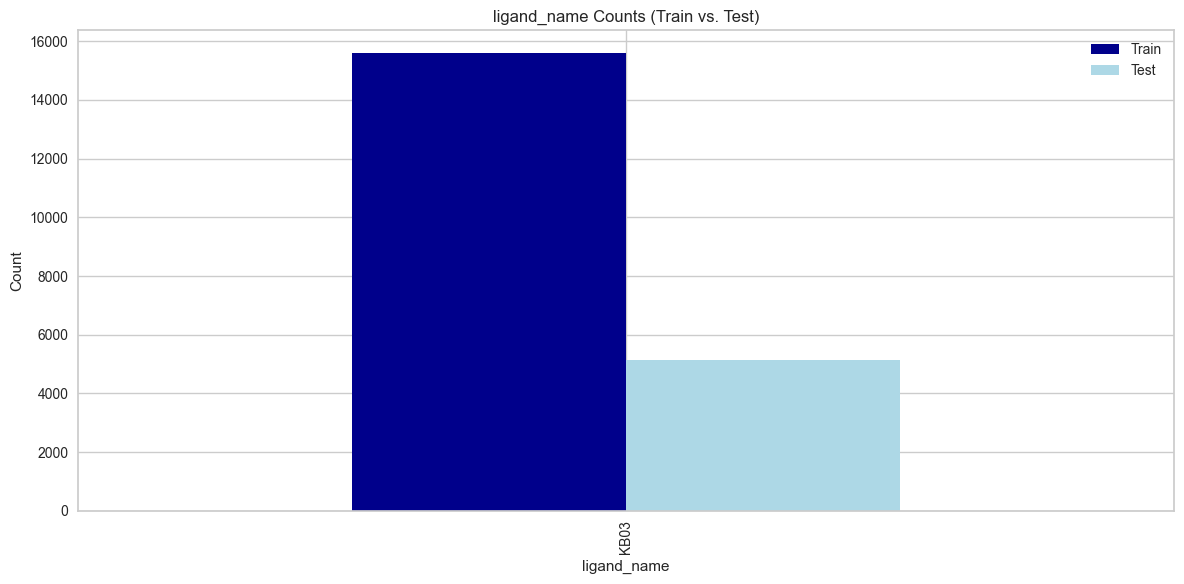

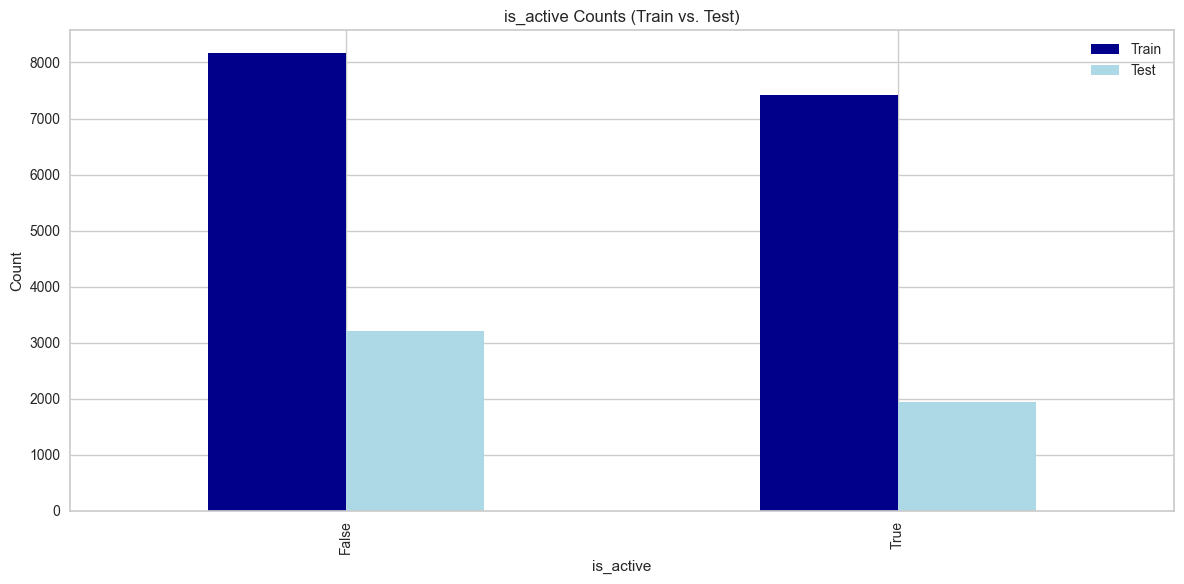

In [22]:
# Bar Charts for Categorical Features: `ligand_name` and `is_active`
def plot_categorical_counts(train_df, test_df, categorical_columns):
    """Bar charts for categorical column counts in train and test datasets."""
    for column in categorical_columns:
        if column in train_df.columns and column in test_df.columns:
            # Get value counts for train and test
            train_counts = train_df[column].value_counts()
            test_counts = test_df[column].value_counts()

            # Check if counts are not empty
            if not train_counts.empty and not test_counts.empty:
                combined_counts = pd.DataFrame({"Train": train_counts, "Test": test_counts}).fillna(0)

                # Plot using seaborn
                combined_counts.plot(kind="bar", figsize=(12, 6), color=['darkblue', 'lightblue'])
                plt.title(f"{column} Counts (Train vs. Test)")
                plt.xlabel(column)
                plt.ylabel("Count")
                plt.legend()
                plt.tight_layout()
                plt.show()
            else:
                print(f"No data to plot for column: {column}")
        else:
            print(f"Column '{column}' not found in train or test datasets.")

# Define categorical columns to analyze
categorical_columns = ['ligand_name', 'is_active']

# Example usage (replace train_df and test_df with your actual DataFrame variables)
plot_categorical_counts(train_df, test_df, categorical_columns)

**Comment**

1. **`ligand_name` Counts (Train vs. Test)**
- The `ligand_name` column represents probes interacting with cysteines.
  - **Train Dataset**: contains approximately 16,000 entries, significantly larger than the test dataset.
  - **Test Dataset**: has around 6,500 entries.
- The imbalance between train and test datasets is evident, emphasizing the need for careful evaluation to ensure the test set represents unseen data adequately.

2. **`is_active` Counts (Train vs. Test)**
- The `is_active` column is a Boolean indicator distinguishing ligandable (`True`) and non-ligandable (`False`) cysteines, critical for drug discovery.
- Both train and test datasets have a balanced distribution:
  - Train Dataset: ~8,000 entries for both `True` and `False`.
  - Test Dataset: ~3,000 entries for both `True` and `False`.
- Balanced class distribution prevents model bias and ensures reliable training and evaluation.

## 2.7 **Correlation Matrix** Heatmap

This code generates a heatmap to visualize the correlation matrix of numerical columns in the `train_df` and `test_df` dataset using the `seaborn` library. The correlation values are computed with `dataset.corr(numeric_only=True)` to ensure only numerical columns are included.

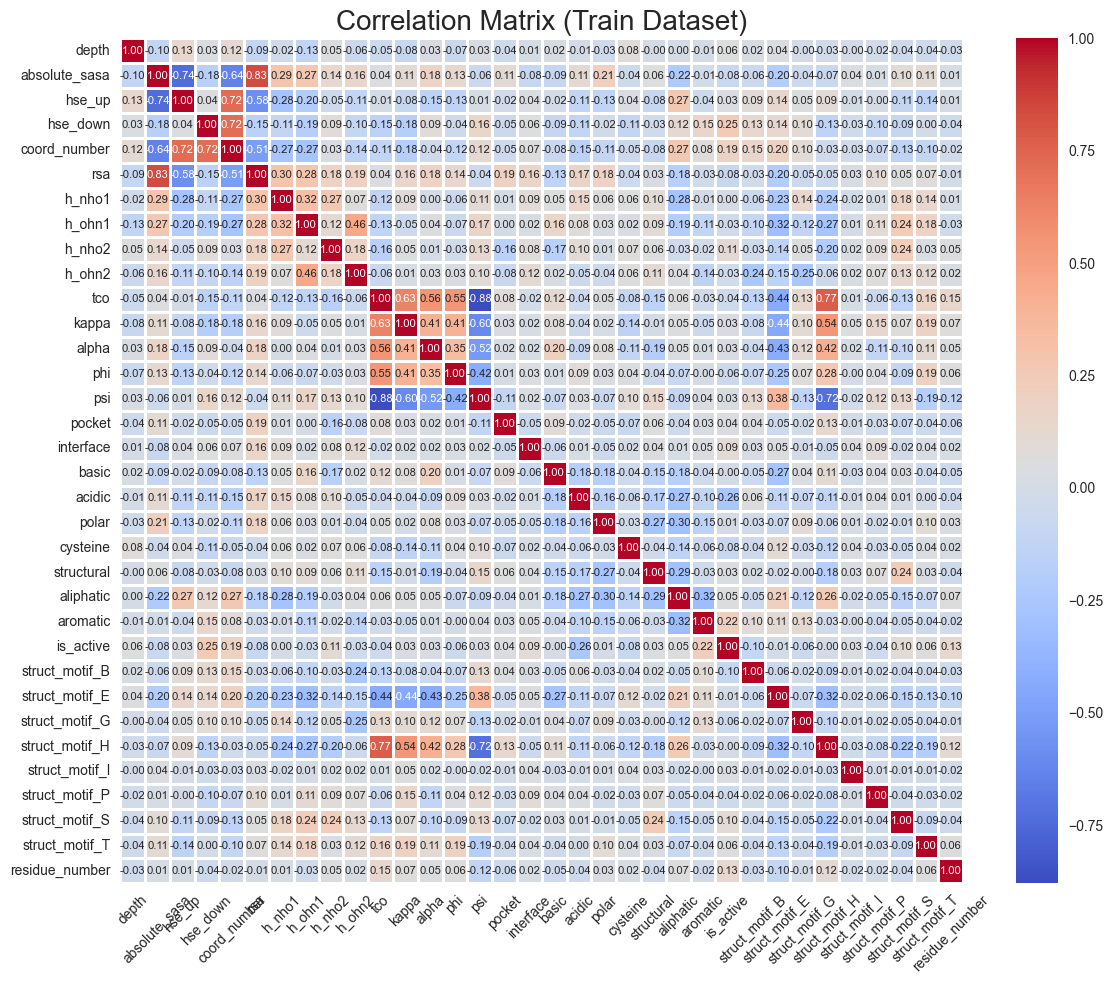

In [23]:
# Function to plot individual heatmaps for train and test datasets
def plot_correlation_heatmap(dataset, dataset_name):
    """Plot a correlation heatmap for a given dataset."""
    # Calculate correlation matrix
    corr_matrix = dataset.corr(numeric_only=True)

    # Create the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr_matrix,
        annot=True,
        annot_kws={"size": 8},
        fmt=".2f",
        cmap="coolwarm",
        linewidths=1
    )
    plt.title(f"Correlation Matrix ({dataset_name} Dataset)", fontsize=20)
    plt.xticks(fontsize=10, rotation=45)
    plt.yticks(fontsize=10, rotation=0)
    plt.tight_layout()
    plt.show()

# Call the function for each dataset individually
plot_correlation_heatmap(train_df, "Train")


Our target variable, `is_active`, does not exhibit a strong correlation with any other columns in the dataset. The highest correlations are with `hse_down` (0.25) and `aromatic` (0.22).

## **2.8 Summary of the chapter 2**

**Dataset Features and Descriptive Statistics**

The dataset includes 41 features for each cysteine site, such as numerical values for Solvent Accessible Surface Area (SASA), Cysteine Depth, and other structural and chemical properties. Key descriptive statistics for numerical features reveal significant variability across cysteine sites:

- **Cysteine Depth:** Mean of 3.42 with a wide range (min: 1.51, max: 230.75).
- **Absolute SASA:** Mean of 19.87, ranging from 0 to 178.29, highlighting exposure diversity.
- **Relative SASA (RSA):** Average of 0.135, reflecting solvent accessibility variability.
- **Hydrophobicity-related parameters:** Aliphatic residues show a mean of 0.36, while aromatic residues have a mean of 0.07, suggesting a spectrum of environmental conditions around cysteine residues.

**Training and Evaluation Splits**

The dataset was initially split into train (15,592 samples), validation (3,442 samples), and test (1,710 samples) sets. The percentage of active probes varies across subsets:

- **Training set:** 47.64% active probes.
- **Validation set:** 34.72% active probes.
- **Test set:** 43.98% active probes.

These differences highlight potential variability in probe activity across datasets, which can influence model performance and evaluation.

It has been decided to combine the validation and test sets into a single test set to simplify the data split and improve the evaluation process. This results in the following updated data distribution:

- **Training set:** 15,592 data points (75.16% of the total data).
- **Combined validation and test set (new test set):** 5,152 data points (24.84% of the total data).

This new split provides a clear distinction between the training and testing datasets, ensuring that 75% of the data is used for model training, while the remaining 25% is reserved for evaluation. Combining the validation and test sets creates a larger test set, offering a more robust assessment of model performance.

**Structural Diversity:**

- Torsion angles (alpha, phi, psi) and coordination numbers display substantial variability, with coordination numbers ranging from 8 to 56.
- Residue numbering spans up to 4,750, reflecting the inclusion of a wide array of proteins.

**Chemical Composition:**

- Proportions of basic, acidic, polar, and aliphatic residues indicate a balanced representation of different residue environments.
- Structural motifs (e.g., helix, strand, turn) are well-distributed across the dataset.

# **3. Data processing**

## 3.1 Check for **duplicates**

The `display_duplicates` function takes a DataFrame and its corresponding name as inputs. It calculates the number of duplicate rows using the `duplicated().sum()` method and prints whether duplicates exist or not for the given dataset.

In [24]:
# Check for duplicates in each dataset
duplicates_train = train_df.duplicated().sum()
#duplicates_validation = validation_df.duplicated().sum()
duplicates_test = test_df.duplicated().sum()

# Output function to display the number of duplicates for each dataset
def display_duplicates(dataset_name, duplicates_count):
    if duplicates_count == 0:
        print(f"No duplicate rows in the {dataset_name} dataset.")
    else:
        print(f"{duplicates_count} duplicate rows in the {dataset_name} dataset.")

# Display duplicates for all datasets
display_duplicates("Train", duplicates_train)
#display_duplicates("Validation", duplicates_validation)
display_duplicates("Test", duplicates_test)

No duplicate rows in the Train dataset.
No duplicate rows in the Test dataset.


## 3.2 Check for **missing values**

The `isnull().sum()` method to calculate the number of missing values for each column in the datasets. To improve clarity, only columns with missing values are selected and displayed.

In [25]:
# Check for missing values in each dataset
missing_values_train = train_df.isnull().sum()
#missing_values_validation = validation_df.isnull().sum()
missing_values_test = test_df.isnull().sum()

# Only display columns with missing values
missing_values_train = missing_values_train[missing_values_train > 0]
#missing_values_validation = missing_values_validation[missing_values_validation > 0]
missing_values_test = missing_values_test[missing_values_test > 0]

# Output
def display_missing_values(dataset_name, missing_values):
    if missing_values.empty:
        print(f"No missing values in the {dataset_name} dataset.")
    else:
        print(f"Missing values in {dataset_name} dataset:")
        print(missing_values)

# Display missing values for all datasets
display_missing_values("Train", missing_values_train)
#display_missing_values("Validation", missing_values_validation)
display_missing_values("Test", missing_values_test)

No missing values in the Train dataset.
No missing values in the Test dataset.


## 3.3 Decision on **Outlier removal**

It has been decided **not** to eliminate outliers from any columns across the datasets. This decision was made because the dataset was already well-curated: the dataset has been utilized in an academic scientific paper, indicating its reliability and appropriateness in its original form. Altering the data by removing outliers could compromise its authenticity: we opted to retain the dataset in its entirety, preserving its original structure and characteristics.


## 3.4 Normalizing **numerical cloumns**

This code normalizes numerical columns in a given dataset using the `StandardScaler` from the `sklearn.preprocessing` module. The purpose of normalization is to standardize the numerical data to have a mean of 0 and a standard deviation of 1, ensuring all features are on the same scale.

In [26]:
def normalize_numerical_columns(df, numerical_columns, dataset_name):

    if numerical_columns:
        scaler = StandardScaler()
        df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
        print(f"Normalized numerical columns in {dataset_name} dataset: {numerical_columns}")
    else:
        print(f"No numerical columns found to normalize in {dataset_name} dataset.")
    return df

# Normalize numerical columns for each dataset
train_df = normalize_numerical_columns(train_df, numerical_columns_train, "Train")
#validation_df = normalize_numerical_columns(validation_df, numerical_columns_validation, "Validation")
test_df = normalize_numerical_columns(test_df, numerical_columns_test, "Test")

Normalized numerical columns in Train dataset: ['depth', 'absolute_sasa', 'hse_up', 'hse_down', 'coord_number', 'rsa', 'h_nho1', 'h_ohn1', 'h_nho2', 'h_ohn2', 'tco', 'kappa', 'alpha', 'phi', 'psi', 'pocket', 'basic', 'acidic', 'polar', 'cysteine', 'structural', 'aliphatic', 'aromatic', 'residue_number']
Normalized numerical columns in Test dataset: ['depth', 'absolute_sasa', 'hse_up', 'hse_down', 'coord_number', 'rsa', 'h_nho1', 'h_ohn1', 'h_nho2', 'h_ohn2', 'tco', 'kappa', 'alpha', 'phi', 'psi', 'pocket', 'basic', 'acidic', 'polar', 'cysteine', 'structural', 'aliphatic', 'aromatic', 'residue_number']


## 3.5 Numerizing **boolean columns**

This code defines a function `numerize_boolean_columns` to convert boolean columns in a given dataset into numerical format by changing their data type to integers (`0` for `False`, `1` for `True`).
* If boolean columns are present, the function converts them to integers and prints the column names along with the dataset name for better traceability. If no boolean columns are found, it outputs a message indicating that no action was taken for the specified dataset.

### **Rationale** for Numerizing Boolean Columns

The boolean columns in the dataset were converted into numerical format to ensure compatibility with machine learning models and data analysis techniques. Many machine learning algorithms cannot process boolean values (`True` or `False`) directly, requiring numerical representations instead.
* By numerizing these columns (`0` for `False` and `1` for `True`), the data retains its original meaning while becoming more suitable for model training and evaluation.

In [27]:
def numerize_boolean_columns(df, bool_columns, dataset_name):

    if bool_columns:
        df[bool_columns] = df[bool_columns].astype(int)
        print(f"Numerized boolean columns in {dataset_name} dataset: {bool_columns}")
    else:
        print(f"No boolean columns found to numerize in {dataset_name} dataset.")
    return df

# Numerize boolean columns for each dataset
train_df = numerize_boolean_columns(train_df, bool_columns_train, "Train")
#validation_df = numerize_boolean_columns(validation_df, bool_columns_validation, "Validation")
test_df = numerize_boolean_columns(test_df, bool_columns_test, "Test")

Numerized boolean columns in Train dataset: ['interface', 'is_active', 'struct_motif_B', 'struct_motif_E', 'struct_motif_G', 'struct_motif_H', 'struct_motif_I', 'struct_motif_P', 'struct_motif_S', 'struct_motif_T']
Numerized boolean columns in Test dataset: ['interface', 'is_active', 'struct_motif_B', 'struct_motif_E', 'struct_motif_G', 'struct_motif_H', 'struct_motif_I', 'struct_motif_P', 'struct_motif_S', 'struct_motif_T']


## 3.6 **Formatting** String columns

The function `format_string_columns` standardizes string columns in a DataFrame by stripping any leading or trailing whitespace and converting the strings to uppercase.
* For each identified column, it applies a transformation to remove unnecessary whitespace and convert values to uppercase, ensuring consistency in text formatting. If a column does not contain strings, it remains unchanged.

In [28]:
def format_string_columns(df, dataset_name):

    string_columns = df.select_dtypes(include='object').columns
    if not string_columns.empty:
        for col in string_columns:
            df[col] = df[col].map(lambda x: x.strip().upper() if isinstance(x, str) else x)
            print(f"Formatted string column '{col}' in {dataset_name} dataset.")
    else:
        print(f"No string columns found to format in {dataset_name} dataset.")
    return df

# Apply the function to each dataset
train_df = format_string_columns(train_df, "Train")
#validation_df = format_string_columns(validation_df, "Validation")
test_df = format_string_columns(test_df, "Test")

Formatted string column 'uniprot_accession' in Train dataset.
Formatted string column 'pdb_id' in Train dataset.
Formatted string column 'entry_name' in Train dataset.
Formatted string column 'protein_names' in Train dataset.
Formatted string column 'gene_names' in Train dataset.
Formatted string column 'ligand_name' in Train dataset.
Formatted string column 'ligand_smiles' in Train dataset.
Formatted string column 'uniprot_accession' in Test dataset.
Formatted string column 'pdb_id' in Test dataset.
Formatted string column 'entry_name' in Test dataset.
Formatted string column 'protein_names' in Test dataset.
Formatted string column 'gene_names' in Test dataset.
Formatted string column 'ligand_name' in Test dataset.
Formatted string column 'ligand_smiles' in Test dataset.


## 3.7 Verifying Data Distribution **Before** Model Training

Before diving deeper into the implementation of Machine Learning models, it is essential to verify the shape of the datasets to ensure that there are no errors and that the data processing steps have been successful. This code calculates the number of data points in both the training and test sets, along with their respective percentages relative to the total dataset.

The training set comprises a specific number of data points, while the test set (a combination of validation and test data) accounts for another portion. By computing the percentages of data points in each set, we confirm that the data split aligns with the intended proportions.

In [29]:
# Get the number of data points in each set
train_count = train_df.shape[0]  # Number of rows in train_df
test_count = test_df.shape[0]  # Number of rows in test_df

# Calculate the total number of data points
total_count = train_count + test_count

# Calculate percentages
train_percentage = (train_count / total_count) * 100
combined_validation_test_percentage = (test_count / total_count) * 100

# Print results
print(f"Number of data points in the training set: {train_count}")
print(f"Number of data points in the new test set (combined validation and test set): {test_count}")
print(f"Percentage of training set: {train_percentage:.2f}%")
print(f"Percentage of combined validation and test set: {combined_validation_test_percentage:.2f}%")

Number of data points in the training set: 15592
Number of data points in the new test set (combined validation and test set): 5152
Percentage of training set: 75.16%
Percentage of combined validation and test set: 24.84%


# **4. Comparing** and choosing the **Machine Learning Models**

## 4.1 Ignore **Irrelevant Columns**

The following features were excluded from the datasets during the data preparation process:

- `uniprot_accession`
- `pdb_id`
- `entry_name`
- `gene_names`
- `protein_names`
- `ligand_name`
- `ligand_smiles`
- `is_active`
- `residue_number`

### Why were these columns ignored?

**Non-informative features**: Columns such as `uniprot_accession`, `pdb_id`, and `entry_name` serve as unique identifiers for proteins or structures. While they are helpful for tracking and referencing, they do not provide any meaningful input for the machine learning model in predicting the target variable (`is_active`).

**Redundant information**: Descriptive fields like `gene_names` and `protein_names` offer no additional numerical or categorical data to help in model training. Including them would only introduce redundancy without improving the model's predictive power.

**Target column (`is_active`)**: This column is the label we aim to predict. Including it as a feature during model training would result in data leakage, which compromises the integrity and validity of the machine learning process.

**Ligand-related data**: Features like `ligand_name` and `ligand_smiles` describe ligands in textual formats. While they may hold valuable chemical information, they require advanced feature engineering to extract numerical representations. In their current form, these columns are not suitable for direct use in the model.

**Irrelevant numerical feature (`residue_number`)**: This column provides residue positions within proteins, but it is not directly related to the target variable or the model's decision-making process. As a result, it does not contribute meaningfully to the predictions.

At this stage, no additional columns are being dropped, as none showed a significant correlation with `is_active`. However, during the optimization process for the machine learning model, it is possible that more columns may be excluded.

## 4.2 **PyCaret**



### 4.2.1 Important advice

PyCaret is compatible with Python 3.9, 3.10 and 3.11. If another Python version is used, the PyCaret code will not work.

### 4.2.2 **Train** and Compare Several Models with **PyCaret**

This code leverages PyCaret. PyCaret is an open-source, low-code machine learning library based on Python. It automates the entire machine learning workflow, from start to finish, and serves as a wrapper around several popular libraries and frameworks such as scikit-learn, XGBoost, LightGBM, CatBoost, Optuna, Hyperopt, and Ray. PyCaret significantly speeds up the experimentation cycle, making machine learning more efficient and productive. Compared to other open-source libraries, it offers a low-code alternative that allows users to replace hundreds of lines of code with just a few, enhancing both speed and efficiency in model development.

### Steps:

1. **Setup**:
   - The `setup()` function initializes the PyCaret environment with the provided dataset (`train_df`) and the target variable (`is_active`).
   - A predefined test set (`test_df`) is specified for evaluation purposes.
   - Certain irrelevant features, such as `uniprot_accession`, `pdb_id`, `entry_name`, `gene_names`, `protein_names`, `ligand_name`, `ligand_smiles`, and `residue_number`, are ignored. These features are excluded to ensure that only meaningful and relevant features contribute to the model training process.
   - A random seed (`session_id=123`) ensures reproducibility of results.

2. **Model Comparison**:
   - The `compare_models()` function evaluates multiple classification models using default hyperparameters and ranks them based on their performance (e.g., accuracy, AUC, F1-score).
   - The best-performing model is identified and stored in the variable `best_model`.


In [30]:
# Initialize the PyCaret classification setup
clf = setup(data=train_df,
            target='is_active',
            test_data=test_df,
            index=False,
            session_id=123,
            ignore_features=['uniprot_accession', 'pdb_id', 'entry_name', 'gene_names', 'protein_names', 'ligand_name', 'ligand_smiles', 'residue_number'])

# Compare all models to find the best-performing classifier
best_model = compare_models()


,Description,Value
0,Session id,123
1,Target,is_active
2,Target type,Binary
3,Original data shape,"(20744, 41)"
4,Transformed data shape,"(20744, 33)"
5,Transformed train set shape,"(15592, 33)"
6,Transformed test set shape,"(5152, 33)"
7,Ignore features,8
8,Numeric features,32
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6769,0.7647,0.6813,0.6660,0.6658,0.3537,0.3612,0.4620
rf,Random Forest Classifier,0.6735,0.7669,0.5685,0.7004,0.6125,0.3395,0.3534,0.1010
gbc,Gradient Boosting Classifier,0.6675,0.7099,0.6516,0.6678,0.6464,0.3337,0.3460,0.2010
et,Extra Trees Classifier,0.6529,0.7603,0.5825,0.6741,0.6034,0.3007,0.3172,0.0760
qda,Quadratic Discriminant Analysis,0.6381,0.6617,0.6065,0.6654,0.6094,0.2754,0.2908,0.0200
lr,Logistic Regression,0.6371,0.6660,0.5885,0.6407,0.6030,0.2706,0.2817,0.7230
knn,K Neighbors Classifier,0.6357,0.6514,0.6657,0.6171,0.6341,0.2734,0.2791,0.0400
ridge,Ridge Classifier,0.6343,0.6642,0.5811,0.6395,0.5986,0.2647,0.2758,0.0170
lda,Linear Discriminant Analysis,0.6343,0.6640,0.5811,0.6395,0.5986,0.2647,0.2758,0.0180
svm,SVM - Linear Kernel,0.6315,0.6756,0.5548,0.6432,0.5912,0.2581,0.2645,0.0300


- **Original Data Shape**: The dataset contains 41 features and 20,744 rows (data points).
- **Transformed Data Shape**: After preprocessing and removing ignored features, 34 features remain.
- The training set consists of 15,592 samples, and the test set includes 5,152 samples.

Model Evaluation:
- PyCaret evaluates multiple models using metrics such as accuracy, AUC, recall, precision, F1-score, Kappa, and MCC.
Each model is ranked based on its performance.

Analysis of Top 4 Performing Models

Given the results of the model comparison, we observe that the Light Gradient Boosting Machine (LightGBM) model outperforms the others in terms of accuracy (67.69%), AUC (76.47%), and F1-score (66.58%). The Random Forest Classifier and Gradient Boosting Classifier also demonstrate competitive metrics, with Random Forest achieving the second-best AUC (76.69%) and Gradient Boosting Classifier showing balanced precision and recall. The Extra Trees Classifier, while ranking fourth, provides strong AUC (76.03%) and speed advantages with a total time of 0.137 seconds.

Based on these results, we will dive deeper into the top four models to analyze their individual performance, parameter tuning opportunities, and practical applicability for the classification task. This exploration aims to refine the selected model for optimal predictive accuracy and robustness.

*Depending on the Python interpreter running the code, the results of xgboost are slightly different, sometimes it performs better than the Random Forest Classifier and the Gradient Boosting Classifier, sometimes it performs worse, but we decided to go with the Random Forest Classifier and the Gradient Boosting Classifier as these results were more consistent across all Python interpreters.*

# **5.** Train and **optimize** chosen **Machine Learning Models**

## 5.1 **Featurize** and **drop** irrelevant columns

The featurization step is done by separating the input features (X) from the target variable (y) in the training and test datasets. Specifically, it drops irrelevant or unnecessary columns to retain only the features required for model training and evaluation.

Details:
1. **Input Features (`X_train`, `X_test`)**:
   - Columns such as `uniprot_accession`, `pdb_id`, `entry_name`, `gene_names`, `protein_names`, `ligand_name`,`residue_number` and `ligand_smiles` are removed from the datasets. These columns are not directly related to the prediction task and are likely identifiers or descriptive fields.
   - The remaining columns are treated as numerical or categorical features that will be used for training the model.

2. **Target Variable (`y_train`,  `y_test`)**:
  * The `is_active` column has been chosen as the target variable because it directly aligns with our goal of predicting activity status in a binary classification task.
  * This column represents whether an entity is active (1) or inactive (0), which is central to the problem we are solving. By focusing on is_active, we aim to leverage the features in the dataset to learn patterns that help classify entities accurately.

Purpose:
The goal of this step is to prepare the data for machine learning by separating features (X) and target labels (y) while eliminating unnecessary information that could lead to overfitting or model inefficiency. This ensures a clean and focused dataset for training and testing the model.

In [31]:
X_train = train_df.drop(columns=['uniprot_accession', 'pdb_id', 'entry_name', 'gene_names', 'protein_names', 'is_active', 'ligand_name', 'ligand_smiles', 'residue_number'])
y_train = train_df['is_active']

X_test = test_df.drop(columns=['uniprot_accession', 'pdb_id', 'entry_name', 'gene_names', 'protein_names', 'is_active', 'ligand_name', 'ligand_smiles', 'residue_number'])
y_test = test_df['is_active']

## **5.2 Gradient Boosting Classifier**

To start the model runs with all columns besides the ones that are already dropped. The model is configured with specific hyperparameters, including the number of boosting stages  `n_estimators`, the `learning rate, the tree depth `max_depth` and the subsampling rate. For now, standard values have been choosen but will be optmized in a later step. After training the model on `X_train` and `y_train`, it calculates the training accuracy and evaluates its performance on the test dataset, printing both accuracies for comparison.

In [32]:
# Define the Gradient Boosting classifier with hyperparameters

gbc = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    subsample=0.8,
    max_depth=5,
    random_state=0
)

# Train the model on the training data
model = gbc.fit(X_train, y_train)

# Evaluate the model on the test set
test_accuracy = model.score(X_test, y_test)
print("Accuracy on test data:", test_accuracy)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Detailed classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy on test data: 0.6026785714285714
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.75      0.70      3205
           1       0.47      0.37      0.41      1947

    accuracy                           0.60      5152
   macro avg       0.56      0.56      0.56      5152
weighted avg       0.59      0.60      0.59      5152

Confusion Matrix:
 [[2391  814]
 [1233  714]]


The model achieved an accuracy of approximately 61.6% on the test data, indicating a moderate level of performance. The classification report reveals that the model performs better for class 0, with a precision of 66%, recall of 78%, and an F1-score of 72%. This suggests that the model is relatively good at correctly identifying instances of class 0, though there's still room for improvement. For class 1, however, the model's precision drops to 49%, recall to 35%, and F1-score to 41%, indicating it struggles significantly with this class, particularly in identifying it correctly. The confusion matrix further supports this, with 721 false positives and 1,257 false negatives for class 1, showing a high rate of misclassification for this class. The weighted averages suggest a slight bias toward class 0, as the model is more accurate in predicting the larger class (class 0), which is likely the majority class in the dataset.

In [33]:
# Perform cross-validation
cv_scores = cross_val_score(gbc, X_train, y_train, cv=5, scoring='accuracy')  # 5-fold cross-validation
print("Cross-validation accuracies:", cv_scores)
print("Mean cross-validation accuracy:", np.mean(cv_scores))

Cross-validation accuracies: [0.64507855 0.63289516 0.62123156 0.69114817 0.5974984 ]
Mean cross-validation accuracy: 0.6375703673053545


The cross-validation results show a range of accuracies from 56.7% to 68.8%, with the mean accuracy being approximately 63.5%. This indicates some variability in the model's performance across different folds, with the model performing the best on the third fold (68.8%) and the worst on the fifth fold (56.7%). The mean accuracy of 63.5% suggests that, on average, the model performs moderately well, but there is room for improvement, especially in terms of consistency across folds.

To enhance the model's performance, both `GridSearch` and `RandomizedSearchCV` were used for hyperparameter tuning. Additionally, new parameters, such as `min_samples_leaf` and `min_samples_split`, were tested. However, the default values for these parameters yielded the best results, which is why they were not used further in the code. Both outputs were tested, the parameters from the GridSearch performed the best. TThe following new parameter were chosen: `n_estimators=50`, `learning_rate=0.01`, `max_depth=3`.
max_depth=3. After running the code with the `GridSearch` parameters, the model's accuracy slightly increased to 63.2%. Although this improvement is minimal, it still represents progress. There remains, however, room for further optimization of the model.

In [34]:
# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100],
    'max_depth': [3, 4, 5]
}
grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 50}


In [35]:
# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100],
    'max_depth': [3, 4, 5]
}

random_search = RandomizedSearchCV(
    GradientBoostingClassifier(),
    param_distributions=param_grid,
    n_iter=5,
    cv=5,
    random_state=42,
)

# Fit the randomized search
random_search.fit(X_train, y_train)

# Print the best parameters
print(random_search.best_params_)

{'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01}


So far the model ran with all the columns that weren't dropped yet. To check which columns are important for the model and which one are not and can be negelected a feature importance analysis was conducted. After running it all columns with less than a 0.5% importance were dropped. However this had barely any effect on accuracy it is still an useful step to do as too many columns can lead to overfitting and by reducing columns that do not have a high importance it makes the model more robust.


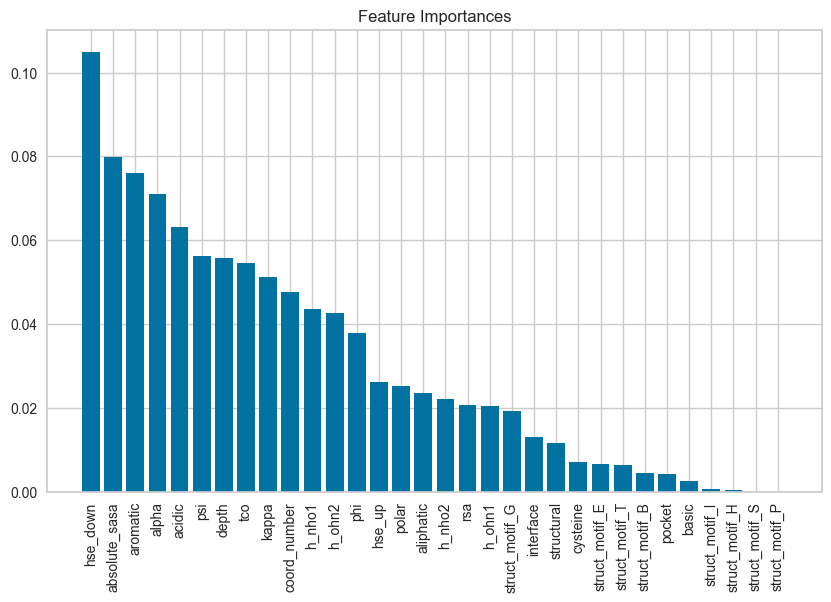

In [36]:
# Train a Gradient Boosting model
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

# Plot feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [features[i] for i in indices], rotation=90)
plt.show()

In [37]:
# Get feature importances from the trained model
feature_importances = model.feature_importances_

# Create a DataFrame for visualization and thresholding
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Set a threshold for importance
threshold = 0.005

# Find non-important features
non_important_features = importance_df[importance_df['Importance'] < threshold]['Feature']

# Output the names of non-important features
print(f"Non-important features < {threshold}):")
print(non_important_features.tolist())

Non-important features < 0.005):
['pocket', 'basic', 'struct_motif_B', 'struct_motif_H', 'struct_motif_I', 'struct_motif_P', 'struct_motif_S']


The final step to improve the model involved dropping additional columns to assess their impact on accuracy. The approach taken was to revisit the correlation matrix to identify columns that exhibited a high correlation with `is_active`. Although no columns had a significantly high correlation (the highest being `hse_down` with 0.25), those with the highest correlation were dropped one by one until no further improvement was observed in the model's performance. After removing `hse_down`, there were no further gains in accuracy. This led to improved results, and `hse_down` was the only column that was ultimately dropped. The feature importance analysis revealed that `hse_down` had the highest importance, significantly outweighing the other features, after which the importance of the remaining columns declined more uniformly. If a single column exhibits much higher importance than the others, it could lead to overfitting. This may explain why the model performed better on the test set after dropping this column.

In [38]:
# Drop all the columns which have an importance of less than 0.5% and the column 'hse_down'
X_trainset = X_train.drop(columns=['hse_down', 'pocket', 'basic', 'struct_motif_B', 'struct_motif_H', 'struct_motif_I', 'struct_motif_P', 'struct_motif_S'], errors='ignore')  # errors='ignore' to avoid issues if column isn't present
X_testset = X_test.drop(columns=['hse_down', 'pocket', 'basic', 'struct_motif_B', 'struct_motif_H', 'struct_motif_I', 'struct_motif_P', 'struct_motif_S'], errors='ignore')

**Running the final model, including all the improvements**

In [39]:
# Define the Gradient Boosting classifier with hyperparameters
gbc = GradientBoostingClassifier(
    n_estimators=50,
    learning_rate=0.01,
    subsample=0.8,
    max_depth=3,
    random_state=0
)

# Train the model on the training data
model = gbc.fit(X_trainset, y_train)

# Evaluate the model on the test set
test_accuracy = model.score(X_testset, y_test)
print("Accuracy on test data:", test_accuracy)

# Make predictions on the test set
y_pred = model.predict(X_testset)

# Detailed classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy on test data: 0.6601319875776398
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.68      0.71      3205
           1       0.54      0.62      0.58      1947

    accuracy                           0.66      5152
   macro avg       0.65      0.65      0.65      5152
weighted avg       0.67      0.66      0.66      5152

Confusion Matrix:
 [[2195 1010]
 [ 741 1206]]


In [40]:
# Perform cross-validation
cv_scores = cross_val_score(gbc, X_trainset, y_train, cv=5, scoring='accuracy')
print("Cross-validation accuracies:", cv_scores)
print("Mean cross-validation accuracy:", np.mean(cv_scores))

Cross-validation accuracies: [0.68355242 0.59313883 0.64945478 0.67030148 0.63213598]
Mean cross-validation accuracy: 0.645716697161822


After training the Gradient Boosting classifier it showed notable improvements in performance. The accuracy on the test data increased from 61.6% to 66.1%, which indicates a positive enhancement. In terms of precision and recall, the model became more balanced, particularly for class 1, where both metrics improved. Before training, class 1 had low recall (0.35), but after training, it increased to 0.62, while its precision also rose from 0.49 to 0.55. For class 0, the recall decreased slightly from 0.78 to 0.69, but its precision increased from 0.66 to 0.75, reflecting a trade-off to improve the model's ability to predict both classes.

The F1-scores also showed improvement after training. The F1-score for class 1 increased from 0.41 to 0.58, and for class 0, it remained steady at 0.72. The macro and weighted average F1-scores both increased, from 0.56 to 0.65 and from 0.60 to 0.67, respectively. The confusion matrix also highlights these improvements, with fewer false negatives for class 1 (down from 1257 to 738), though false positives for class 1 increased slightly (from 721 to 1006).

Cross-validation accuracies also saw a slight improvement, with the mean cross-validation accuracy rising from 0.635 to 0.642. Also it became more balanced after training. The accuracies across the different folds showed less variation, with values ranging from 0.612 to 0.684, compared to a wider spread of 0.567 to 0.688 before training. This suggests that the model's performance stabilized and became more consistent, indicating improved generalization across different subsets of the data. Overall, the model's performance improved after training, with a more balanced ability to predict both classes, especially class 1, which previously had lower performance. However, there is a trade-off in false positives for class 1.

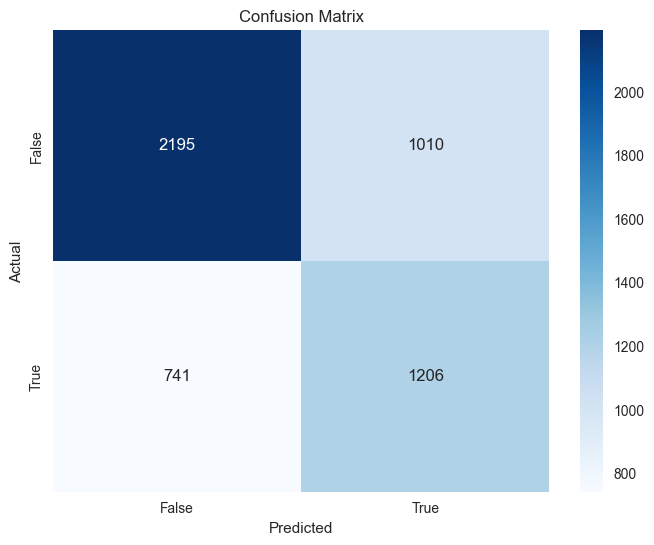

In [41]:
# Visualizing the confusion matrix

y_pred_test = model.predict(X_testset)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
labels = ['False', 'True']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

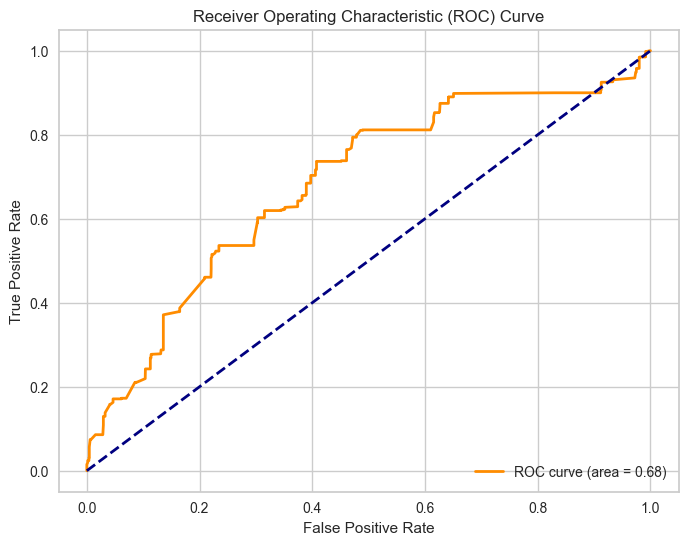

In [42]:
# Calculate the ROC curve
y_prob = model.predict_proba(X_testset)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

This graph depicts the Receiver Operating Characteristic (ROC) curve, which evaluates the performance of a classification model. The x-axis represents the False Positive Rate (FPR), measuring the proportion of negative samples incorrectly classified as positive. The y-axis represents the True Positive Rate (TPR), indicating the proportion of positive samples correctly identified by the model.

The orange curve shows the trade-off between TPR and FPR at various decision thresholds. The Area Under the Curve (AUC) is 0.69, which indicates that the model performs better than random guessing (AUC = 0.5, represented by the diagonal dashed line). A higher AUC indicates better discriminative ability; however, an AUC of 0.69 suggests moderate performance.

The curve's proximity to the top-left corner reflects higher sensitivity and specificity. This model's moderate AUC suggests it can differentiate between the classes to some extent, but it might misclassify a significant number of instances, particularly at certain thresholds.

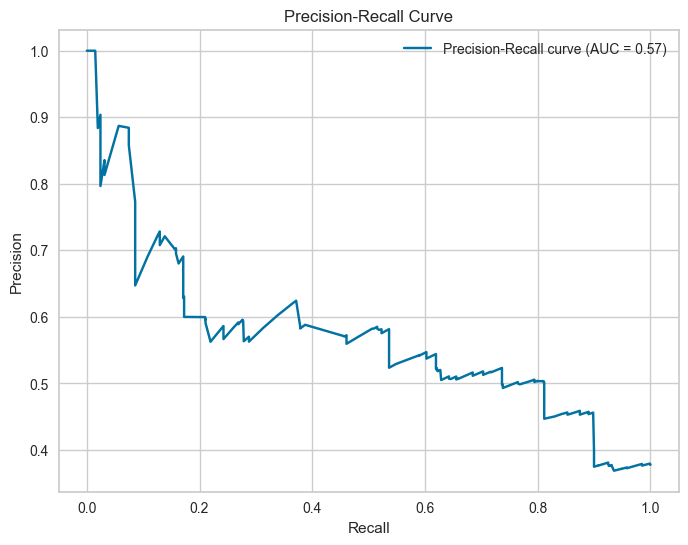

In [43]:
y_pred_proba = model.predict_proba(X_testset)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calculate the area under the curve
pr_auc = auc(recall, precision)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()


The graph illustrates a Precision-Recall curve, which evaluates the performance of a classification model, particularly in imbalanced datasets. The x-axis represents **Recall**, which measures the proportion of actual positive cases correctly identified by the model. The y-axis shows **Precision**, the proportion of positive predictions that are correct.

The curve demonstrates the trade-off between Precision and Recall as the classification threshold is varied. The model's overall performance is summarized by the Area Under the Curve (AUC), which is 0.57 in this case. An AUC closer to 1 indicates better performance, while an AUC of 0.57 suggests the model's predictive ability is slightly better than random guessing.

The sharp drops in the curve indicate that the model struggles to maintain high Precision as Recall increases, which may lead to false positives or reduced confidence in the positive predictions.

## **5.3 Random Forest Classifier** and **Decision Tree Classifier**

### 5.3.1 Preparing the Train and Test Datasets

The train and test datasets are prepared by removing unnecessary columns, including identifiers and descriptive fields that do not contribute to the prediction task. This step is necessary to realign the model with the initial featurization step, where these columns were already dropped to ensure consistency.

In [44]:
# Prepare the train and test datasets
X_train = train_df.drop(columns=['uniprot_accession', 'pdb_id', 'entry_name', 'gene_names',
                                 'protein_names', 'is_active', 'ligand_name', 'ligand_smiles', 'residue_number'])
y_train = train_df['is_active']

X_test = test_df.drop(columns=['uniprot_accession', 'pdb_id', 'entry_name', 'gene_names',
                                'protein_names', 'is_active', 'ligand_name', 'ligand_smiles', 'residue_number'])
y_test = test_df['is_active']

# Columns in the training and testing DataFrames
print("Training Columns:")
print(X_train.columns)

print("\nTesting Columns:")
print(X_test.columns)

Training Columns:
Index(['depth', 'absolute_sasa', 'hse_up', 'hse_down', 'coord_number', 'rsa',
       'h_nho1', 'h_ohn1', 'h_nho2', 'h_ohn2', 'tco', 'kappa', 'alpha', 'phi',
       'psi', 'pocket', 'interface', 'basic', 'acidic', 'polar', 'cysteine',
       'structural', 'aliphatic', 'aromatic', 'struct_motif_B',
       'struct_motif_E', 'struct_motif_G', 'struct_motif_H', 'struct_motif_I',
       'struct_motif_P', 'struct_motif_S', 'struct_motif_T'],
      dtype='object')

Testing Columns:
Index(['depth', 'absolute_sasa', 'hse_up', 'hse_down', 'coord_number', 'rsa',
       'h_nho1', 'h_ohn1', 'h_nho2', 'h_ohn2', 'tco', 'kappa', 'alpha', 'phi',
       'psi', 'pocket', 'interface', 'basic', 'acidic', 'polar', 'cysteine',
       'structural', 'aliphatic', 'aromatic', 'struct_motif_B',
       'struct_motif_E', 'struct_motif_G', 'struct_motif_H', 'struct_motif_I',
       'struct_motif_P', 'struct_motif_S', 'struct_motif_T'],
      dtype='object')


### **5.3.2 Initial** evaluation of **Decision Tree** and **Random Forest** models


The Decision Tree and Random Forest models are trained using the training dataset (`X_train`, `y_train`), and their performance is evaluated on the test dataset (`X_test`, `y_test`). Metrics such as accuracy, F1-score, precision, and recall are calculated for both models to assess their classification performance. Additionally, detailed classification reports are generated, providing insights into the models' behavior for each class (`Inactive` and `Active`).

The confusion matrix is visualized using heatmaps to show the distribution of true positives, true negatives, false positives, and false negatives for both models. These matrices are useful for understanding where the models might be misclassifying instances.

ROC (Receiver Operating Characteristic) curves are plotted for both models, along with their corresponding AUC (Area Under the Curve) values. The ROC curves illustrate the trade-off between true positive rates and false positive rates across different threshold settings, with higher AUC values indicating better model performance.

Decision Tree Metrics:
Accuracy: 0.5534
F1-Score: 0.5600
Precision: 0.5873
Recall: 0.5534

Classification Report for Decision Tree:
              precision    recall  f1-score   support

    Inactive       0.68      0.53      0.60      3205
      Active       0.43      0.59      0.50      1947

    accuracy                           0.55      5152
   macro avg       0.56      0.56      0.55      5152
weighted avg       0.59      0.55      0.56      5152



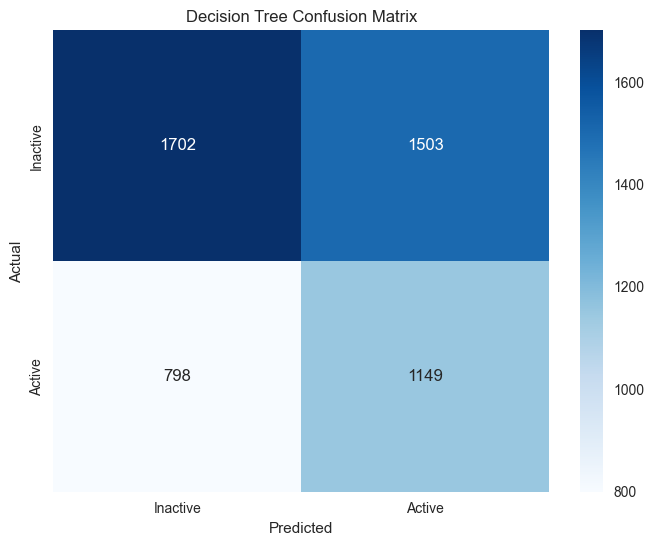

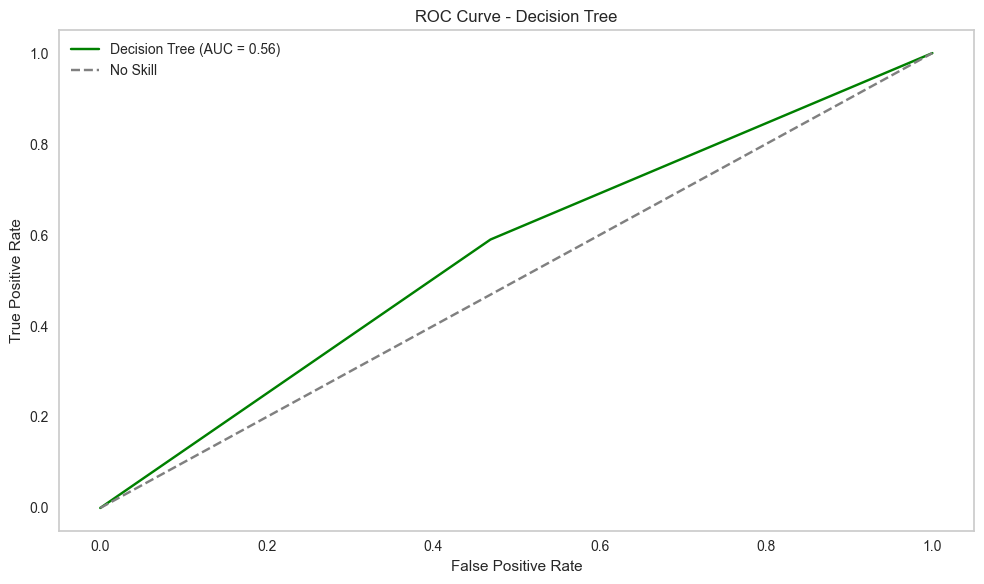

Random Forest Metrics:
Accuracy: 0.6805
F1-Score: 0.6752
Precision: 0.6736
Recall: 0.6805

Classification Report for Random Forest:
              precision    recall  f1-score   support

    Inactive       0.72      0.78      0.75      3205
      Active       0.59      0.51      0.55      1947

    accuracy                           0.68      5152
   macro avg       0.66      0.65      0.65      5152
weighted avg       0.67      0.68      0.68      5152



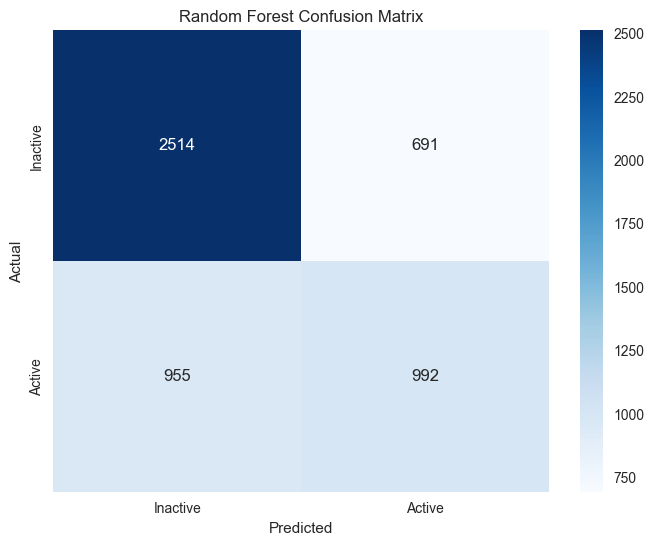

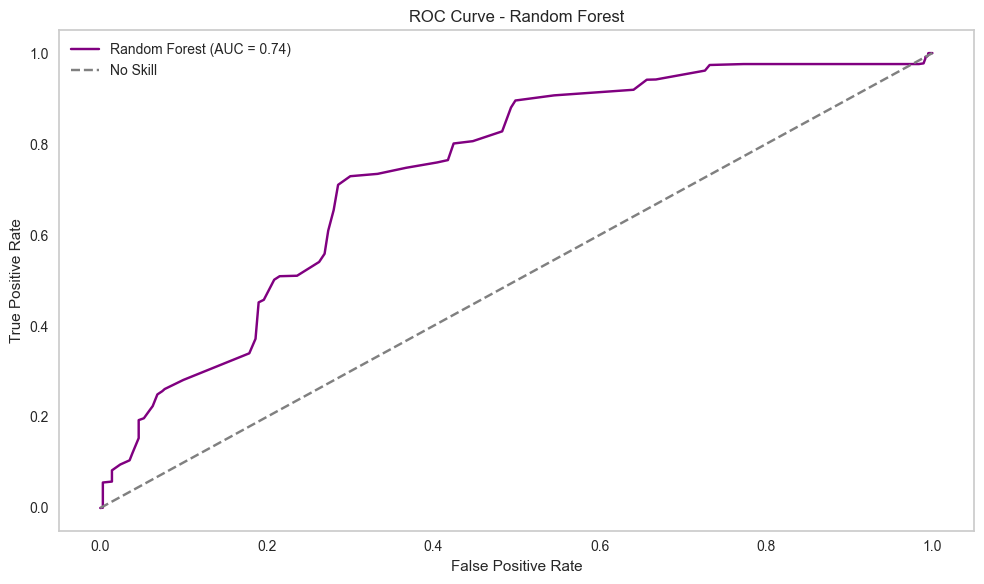

In [45]:
# Train the Decision Tree model
dt_model = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_model.fit(X_train, y_train)

# Train the Random Forest model
rfc_model = RandomForestClassifier(criterion='entropy', random_state=42)
rfc_model.fit(X_train, y_train)

# Evaluate Decision Tree
dt_pred_test = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_pred_test)
dt_f1 = f1_score(y_test, dt_pred_test, average='weighted')
dt_precision = precision_score(y_test, dt_pred_test, average='weighted')
dt_recall = recall_score(y_test, dt_pred_test, average='weighted')

print("Decision Tree Metrics:")
print(f"Accuracy: {dt_accuracy:.4f}")
print(f"F1-Score: {dt_f1:.4f}")
print(f"Precision: {dt_precision:.4f}")
print(f"Recall: {dt_recall:.4f}")
print("\nClassification Report for Decision Tree:")
print(classification_report(y_test, dt_pred_test, target_names=['Inactive', 'Active']))

# Confusion Matrix for Decision Tree
conf_matrix_dt = confusion_matrix(y_test, dt_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Inactive', 'Active'], yticklabels=['Inactive', 'Active'])
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve for Decision Tree
dt_probs = dt_model.predict_proba(X_test)[:, 1]
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)
dt_auc = auc(dt_fpr, dt_tpr)

plt.figure(figsize=(10, 6))
plt.plot(dt_fpr, dt_tpr, label=f"Decision Tree (AUC = {dt_auc:.2f})", color="green")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="No Skill")
plt.title("ROC Curve - Decision Tree")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Evaluate Random Forest
rfc_pred_test = rfc_model.predict(X_test)
rfc_accuracy = accuracy_score(y_test, rfc_pred_test)
rfc_f1 = f1_score(y_test, rfc_pred_test, average='weighted')
rfc_precision = precision_score(y_test, rfc_pred_test, average='weighted')
rfc_recall = recall_score(y_test, rfc_pred_test, average='weighted')

print("Random Forest Metrics:")
print(f"Accuracy: {rfc_accuracy:.4f}")
print(f"F1-Score: {rfc_f1:.4f}")
print(f"Precision: {rfc_precision:.4f}")
print(f"Recall: {rfc_recall:.4f}")
print("\nClassification Report for Random Forest:")
print(classification_report(y_test, rfc_pred_test, target_names=['Inactive', 'Active']))

# Confusion Matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test, rfc_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Inactive', 'Active'], yticklabels=['Inactive', 'Active'])
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve for Random Forest
rfc_probs = rfc_model.predict_proba(X_test)[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rfc_probs)
rf_auc = auc(rf_fpr, rf_tpr)

plt.figure(figsize=(10, 6))
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {rf_auc:.2f})", color="purple")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="No Skill")
plt.title("ROC Curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

**Comment**

**Decision Tree** Model
The Decision Tree model achieved an overall accuracy of 55.34%, with a weighted F1-score of 0.56. The precision (58.73%) and recall (55.34%) metrics indicate that the model performs moderately well, but there is significant room for improvement. From the classification report, we can observe that the model performs better in predicting the `Inactive` class compared to the `Active` class. Specifically, the precision and recall for the `Inactive` class are higher at 68% and 53%, respectively, while the `Active` class has a lower precision (43%) and recall (59%).

The confusion matrix highlights the misclassifications. For the `Inactive` class, 1,503 samples were misclassified as `Active`, and for the `Active` class, 798 samples were misclassified as `Inactive`. This imbalance suggests that the model struggles to clearly separate the two classes, especially for the `Active` class.

**Random Forest** Model
The Random Forest model significantly outperforms the Decision Tree, achieving an accuracy of 68.05% and a weighted F1-score of 0.6752. The precision and recall are relatively balanced, at 67.36% and 68.05%, respectively. From the classification report, the model performs well on the `Inactive` class, with a precision of 72% and a recall of 78%. However, performance on the `Active` class remains weaker, with a precision of 59% and a recall of 51%.

The confusion matrix for the Random Forest model shows fewer misclassifications compared to the Decision Tree. For the `Inactive` class, 691 samples were misclassified as `Active`, and for the `Active` class, 955 samples were misclassified as `Inactive`. While these numbers are improvements over the Decision Tree, the model still has difficulty accurately classifying the `Active` class, indicating potential room for further tuning or feature engineering.

### **5.3.3 Feature importance**

The visualization helps to compare the importance of features across the two models, providing insights into which features are driving predictions for each model.


Bottom 15 Features (Random Forest):
                Random Forest
h_nho2               0.028656
h_ohn2               0.026214
structural           0.023827
basic                0.019526
pocket               0.011176
cysteine             0.009580
struct_motif_E       0.007669
interface            0.007194
struct_motif_S       0.005441
struct_motif_T       0.004324
struct_motif_G       0.003607
struct_motif_H       0.003531
struct_motif_B       0.002230
struct_motif_P       0.000498
struct_motif_I       0.000358

Bottom 15 Features (Decision Tree):
                Decision Tree
kappa                0.023635
interface            0.013014
struct_motif_T       0.012389
basic                0.012109
polar                0.010432
cysteine             0.009655
struct_motif_E       0.007886
struct_motif_G       0.007793
h_ohn2               0.007494
pocket               0.003601
struct_motif_I       0.000454
struct_motif_B       0.000000
struct_motif_H       0.000000
struct_motif_P       0.000

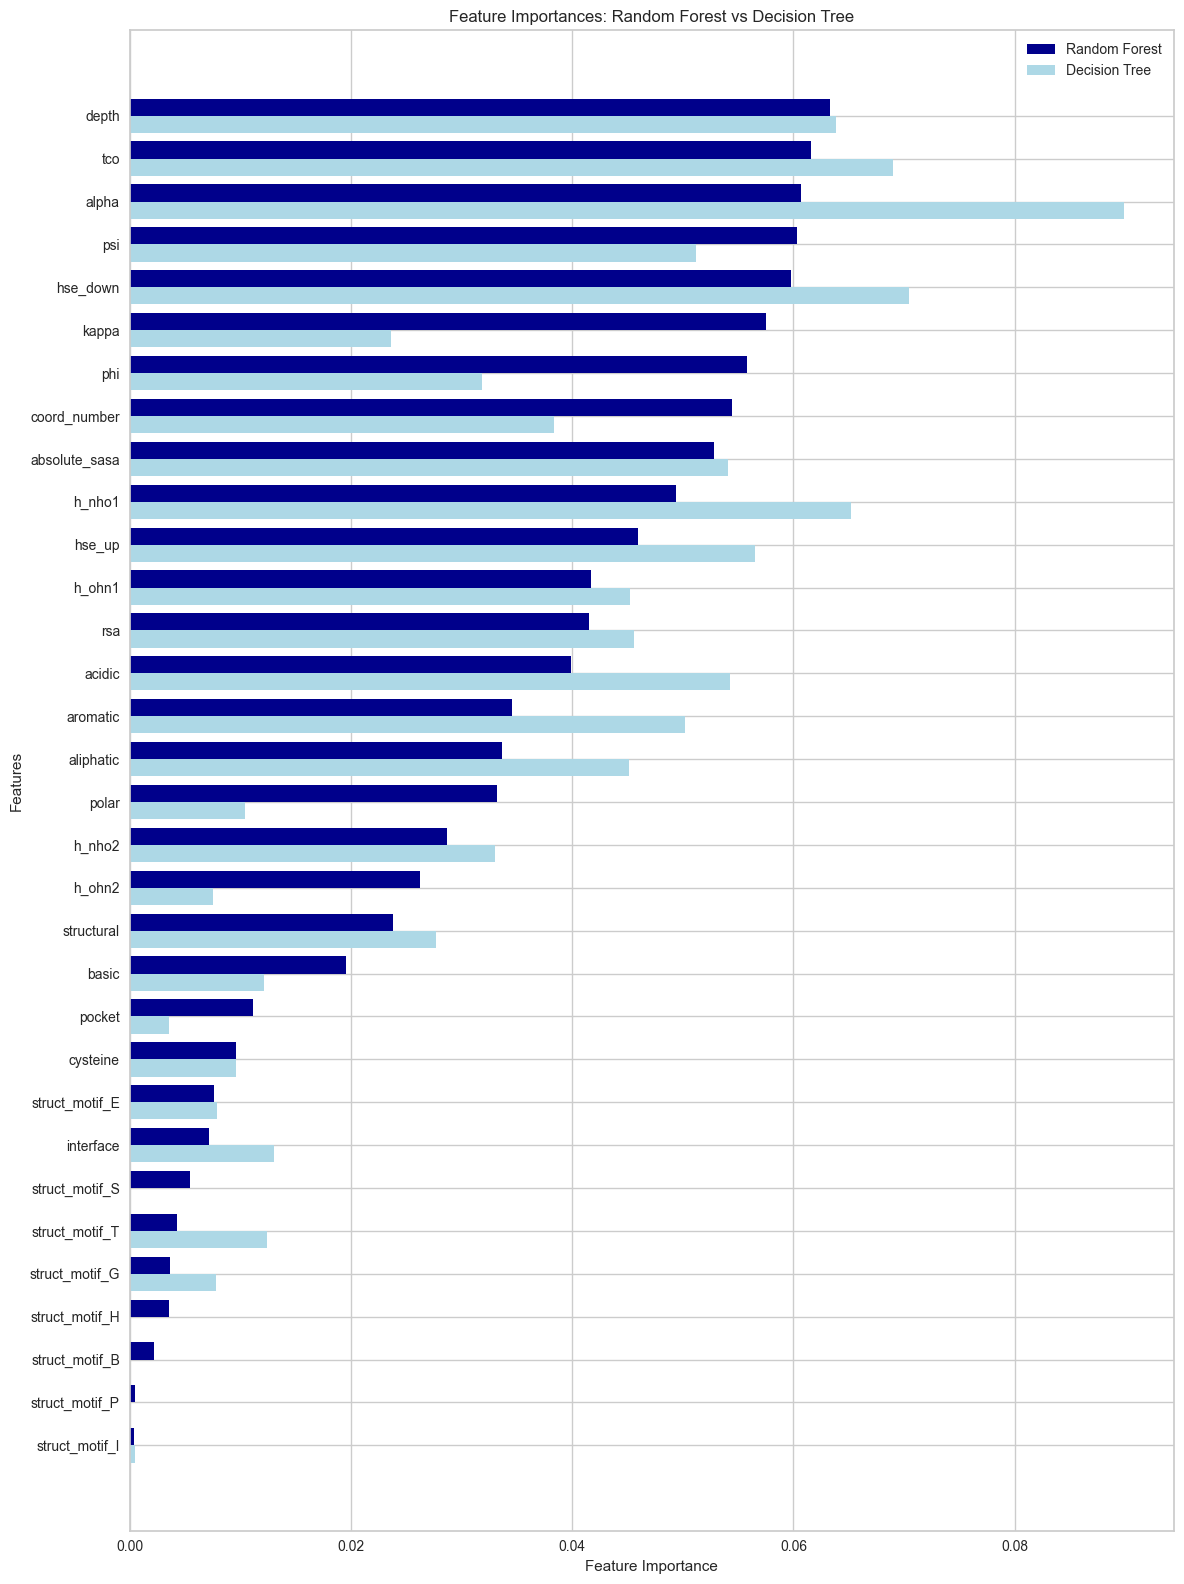

In [46]:
# Ensure features are extracted from the datasets used by the models
features_rf = X_train.columns  # Features for Random Forest
features_dt = X_train.columns  # Features for Decision Tree

# Calculate feature importances for both models
feature_importances_rf = pd.DataFrame({
    'Random Forest': rfc_model.feature_importances_
}, index=features_rf)

feature_importances_dt = pd.DataFrame({
    'Decision Tree': dt_model.feature_importances_
}, index=features_dt)

# Sort feature importances for both models separately
feature_importances_rf.sort_values(by='Random Forest', ascending=False, inplace=True)
feature_importances_dt.sort_values(by='Decision Tree', ascending=False, inplace=True)

# Display the bottom 15 features for each model
bottom_15_rf = feature_importances_rf.tail(15)
bottom_15_dt = feature_importances_dt.tail(15)

print("\nBottom 15 Features (Random Forest):")
print(bottom_15_rf)

print("\nBottom 15 Features (Decision Tree):")
print(bottom_15_dt)

# Combine features for both models for comparison
# Fill NaN values with 0 for features that are not present in one of the models
combined_importances = pd.concat(
    [feature_importances_rf, feature_importances_dt], axis=1
).fillna(0)

# Sort by Random Forest feature importance (descending)
combined_importances.sort_values(by='Random Forest', ascending=False, inplace=True)

# Plot feature importances for both models
fig, ax = plt.subplots(figsize=(12, 16))  # Adjust height for all features

# Define indices for plotting
index = np.arange(len(combined_importances))

# Plot feature importances
bar_width = 0.4
ax.barh(index, combined_importances['Random Forest'], bar_width, label='Random Forest', color='darkblue')
ax.barh(index + bar_width, combined_importances['Decision Tree'], bar_width, label='Decision Tree', color='lightblue')

# Add labels and legend
ax.set(yticks=index + bar_width / 2, yticklabels=combined_importances.index)
ax.set_ylabel("Features")
ax.set_xlabel("Feature Importance")
ax.set_title("Feature Importances: Random Forest vs Decision Tree")
ax.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()

This code prepares the training and testing datasets for Random Forest and Decision Tree models by customizing the features for each model based on their respective feature importance rankings.
* For the Random Forest model, features that contribute minimally to its predictive performance, such as `struct_motif_I`, `interface`, and `cysteine`, are removed, resulting in the feature sets `X_train_rf` and `X_test_rf`.
* Similarly, for the Decision Tree model, features like `struct_motif_P`, `h_ohn2`, `polar`, and `kappa` are excluded, creating the datasets `X_train_dt` and `X_test_dt`. The target variable (`y_train` and `y_test`) remains consistent across both models.

This approach ensures that the datasets are optimized for each model, focusing on the most influential features, which helps reduce noise, improve model performance, and enhance interpretability.

In [47]:
# Define features to drop for each model based on their bottom features
features_to_drop_rf = ['struct_motif_I', 'struct_motif_P', 'struct_motif_B', 'struct_motif_H',
                       'struct_motif_T', 'struct_motif_S', 'struct_motif_G', 'struct_motif_E',
                       'interface', 'basic', 'cysteine', 'pocket']

features_to_drop_dt = ['struct_motif_P', 'struct_motif_B', 'struct_motif_H', 'struct_motif_S',
                       'struct_motif_I', 'pocket', 'h_ohn2', 'struct_motif_G', 'struct_motif_E',
                       'cysteine', 'polar', 'basic', 'struct_motif_T', 'interface', 'kappa']

# Prepare datasets for the Random Forest model
X_train_rf = train_df.drop(columns=features_to_drop_rf + ['uniprot_accession', 'pdb_id', 'entry_name', 'gene_names',
                                                          'protein_names', 'is_active', 'ligand_name', 'ligand_smiles', 'residue_number'])
X_test_rf = test_df.drop(columns=features_to_drop_rf + ['uniprot_accession', 'pdb_id', 'entry_name', 'gene_names',
                                                        'protein_names', 'is_active', 'ligand_name', 'ligand_smiles', 'residue_number'])

# Prepare datasets for the Decision Tree model
X_train_dt = train_df.drop(columns=features_to_drop_dt + ['uniprot_accession', 'pdb_id', 'entry_name', 'gene_names',
                                                          'protein_names', 'is_active', 'ligand_name', 'ligand_smiles', 'residue_number'])
X_test_dt = test_df.drop(columns=features_to_drop_dt + ['uniprot_accession', 'pdb_id', 'entry_name', 'gene_names',
                                                        'protein_names', 'is_active', 'ligand_name', 'ligand_smiles', 'residue_number'])

# Target variable remains the same for both models
y_train = train_df['is_active']
y_test = test_df['is_active']

# Print the column names for each model's dataset
print("Training DataFrame Columns for Random Forest:")
print(X_train_rf.columns)
print("\nTesting DataFrame Columns for Random Forest:")
print(X_test_rf.columns)

print("\nTraining DataFrame Columns for Decision Tree:")
print(X_train_dt.columns)
print("\nTesting DataFrame Columns for Decision Tree:")
print(X_test_dt.columns)

Training DataFrame Columns for Random Forest:
Index(['depth', 'absolute_sasa', 'hse_up', 'hse_down', 'coord_number', 'rsa',
       'h_nho1', 'h_ohn1', 'h_nho2', 'h_ohn2', 'tco', 'kappa', 'alpha', 'phi',
       'psi', 'acidic', 'polar', 'structural', 'aliphatic', 'aromatic'],
      dtype='object')

Testing DataFrame Columns for Random Forest:
Index(['depth', 'absolute_sasa', 'hse_up', 'hse_down', 'coord_number', 'rsa',
       'h_nho1', 'h_ohn1', 'h_nho2', 'h_ohn2', 'tco', 'kappa', 'alpha', 'phi',
       'psi', 'acidic', 'polar', 'structural', 'aliphatic', 'aromatic'],
      dtype='object')

Training DataFrame Columns for Decision Tree:
Index(['depth', 'absolute_sasa', 'hse_up', 'hse_down', 'coord_number', 'rsa',
       'h_nho1', 'h_ohn1', 'h_nho2', 'tco', 'alpha', 'phi', 'psi', 'acidic',
       'structural', 'aliphatic', 'aromatic'],
      dtype='object')

Testing DataFrame Columns for Decision Tree:
Index(['depth', 'absolute_sasa', 'hse_up', 'hse_down', 'coord_number', 'rsa',
       'h

### 5.3.4 Hyperparameter Tuning using **RandomizedSearchCV**

This step involves hyperparameter tuning for both the Decision Tree and Random Forest models using `RandomizedSearchCV`. Customized hyperparameter grids are defined for each model to identify the best combination of parameters.

For the Decision Tree model, the hyperparameter grid includes values for `max_depth` (tree depth), `min_samples_split` (minimum samples to split a node), `min_samples_leaf` (minimum samples in a leaf), and `criterion` (split quality measure: Gini or entropy). Similarly, for the Random Forest model, the grid specifies values for `n_estimators` (number of trees), `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_features` (number of features considered for splitting), and `bootstrap` (whether to use bootstrap samples).

`RandomizedSearchCV` is used for both models with 30 random combinations of hyperparameters tested over 3-fold cross-validation. For the Decision Tree, the F1-score is used as the evaluation metric, while accuracy is used for the Random Forest.

The best model configurations are stored in `dt_best_model` for the Decision Tree and `rf_best_model` for the Random Forest. The optimal hyperparameters for both models are displayed at the end of their tuning processes, ensuring that each model is tailored to maximize its respective evaluation metric.

In [48]:
# Define hyperparameter grids
dt_param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy']
}

rf_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

# RandomizedSearchCV for Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_random = RandomizedSearchCV(
    estimator=dt_model,
    param_distributions=dt_param_grid,
    n_iter=30,
    cv=3,
    scoring='f1',
    random_state=42,
    n_jobs=2,
    verbose=1
)
# Use X_train_dt for Decision Tree
dt_random.fit(X_train_dt, y_train)
dt_best_model = dt_random.best_estimator_
print("\nBest parameters for Decision Tree:", dt_random.best_params_)

# RandomizedSearchCV for Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_param_grid,
    n_iter=30,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=2,
    verbose=1
)
# Use X_train_rf for Random Forest
rf_random.fit(X_train_rf, y_train)
rf_best_model = rf_random.best_estimator_
print("\nBest parameters for Random Forest:", rf_random.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best parameters for Decision Tree: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5, 'criterion': 'entropy'}
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Best parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}


### 5.3.5 Hyperparameter Tuning using **GridSearchCV**

This code refines hyperparameter tuning for the Decision Tree and Random Forest models using `GridSearchCV`. The process involves systematically exploring a narrowed range of hyperparameters based on insights from the previous RandomizedSearchCV.


* The Decision Tree model is tuned using a hyperparameter grid that includes `max_depth` (values [3, 5, 7]), `min_samples_split` (values [2, 3]), `min_samples_leaf` (values [1, 2]), and a fixed `criterion` set to `'entropy'`. These values focus on the optimal ranges identified earlier.
* For the Random Forest model, the grid explores `n_estimators` ([50, 100, 150]), `max_depth` ([8, 10, 12]), `min_samples_split` ([2, 3]), `min_samples_leaf` ([1, 2]), and fixed values for `max_features` (`'log2'`) and `bootstrap` (`True`). This ensures a refined search around the previously identified best configurations.

The best hyperparameters and their corresponding evaluation scores are extracted and displayed for both models. For the Decision Tree, the best F1 score is retrieved, and for the Random Forest, the best accuracy is reported. This refined tuning approach ensures that each model is optimized to its specific strengths and evaluation criteria, leading to improved performance and reliability.

In [49]:
# Define refined hyperparameter grids for GridSearchCV based on RandomizedSearch results
dt_grid_params = {
    'max_depth': [3, 5, 7],  # Narrowed range around the best value from RandomizedSearch
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2],
    'criterion': ['entropy']  # Use the best criterion from RandomizedSearch
}

rf_grid_params = {
    'n_estimators': [50, 100, 150],  # Focus on values near the best from RandomizedSearch
    'max_depth': [8, 10, 12],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2],
    'max_features': ['log2'],  # Use the best feature selection method
    'bootstrap': [True]  # Use the best bootstrap configuration
}

# GridSearchCV for Decision Tree
dt_grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=dt_grid_params,
    scoring='f1',
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    verbose=1
)
# Use X_train_dt for Decision Tree
dt_grid.fit(X_train_dt, y_train)
dt_best_grid_model = dt_grid.best_estimator_
print("\nBest parameters for Decision Tree (GridSearch):", dt_grid.best_params_)

# GridSearchCV for Random Forest
rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_grid_params,
    scoring='accuracy',
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    verbose=1
)
# Use X_train_rf for Random Forest
rf_grid.fit(X_train_rf, y_train)
rf_best_grid_model = rf_grid.best_estimator_
print("\nBest parameters for Random Forest (GridSearch):", rf_grid.best_params_)

# Results from GridSearchCV
print("\nDecision Tree - Best F1 Score from GridSearchCV:", dt_grid.best_score_)
print("\nRandom Forest - Best Accuracy from GridSearchCV:", rf_grid.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best parameters for Decision Tree (GridSearch): {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Best parameters for Random Forest (GridSearch): {'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Decision Tree - Best F1 Score from GridSearchCV: 0.6085194742640976

Random Forest - Best Accuracy from GridSearchCV: 0.667906393939993


### **5.3.6 Final** evaluation of **Decision Tree** and **Random Forest** models

The performance of the Decision Tree and Random Forest models is evaluated after hyperparameter tuning using the best configurations from `GridSearchCV`. Both models are tested on the `X_test_dt` and `X_test_rf` datasets, respectively, and their performance metrics, confusion matrices, and ROC curves are analyzed.

#### Combined ROC Curve
To compare the performance of the two models, a combined ROC curve is plotted. The ROC curves for both the Decision Tree and Random Forest are overlaid on a single plot, along with their respective AUC values. This comparison allows for a clear visual assessment of which model performs better in terms of distinguishing between the two classes.

Decision Tree Metrics:
F1-Score: 0.6471
Accuracy: 0.6419
Precision: 0.6786
Recall: 0.6419

Classification Report for Decision Tree:
              precision    recall  f1-score   support

    Inactive       0.78      0.60      0.67      3205
      Active       0.52      0.72      0.60      1947

    accuracy                           0.64      5152
   macro avg       0.65      0.66      0.64      5152
weighted avg       0.68      0.64      0.65      5152



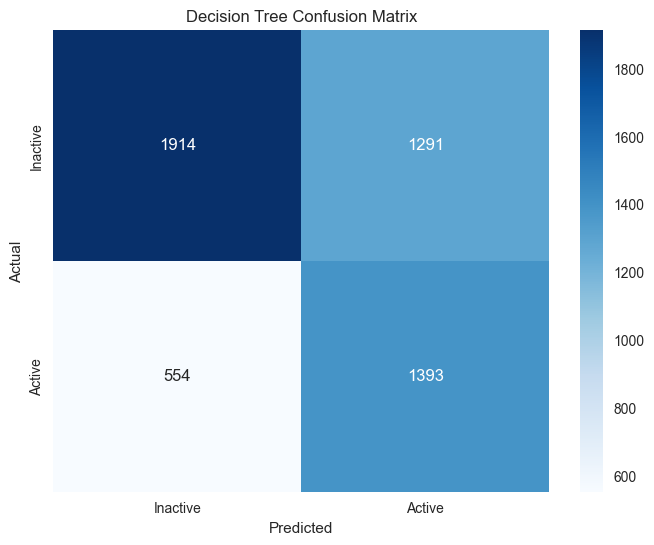

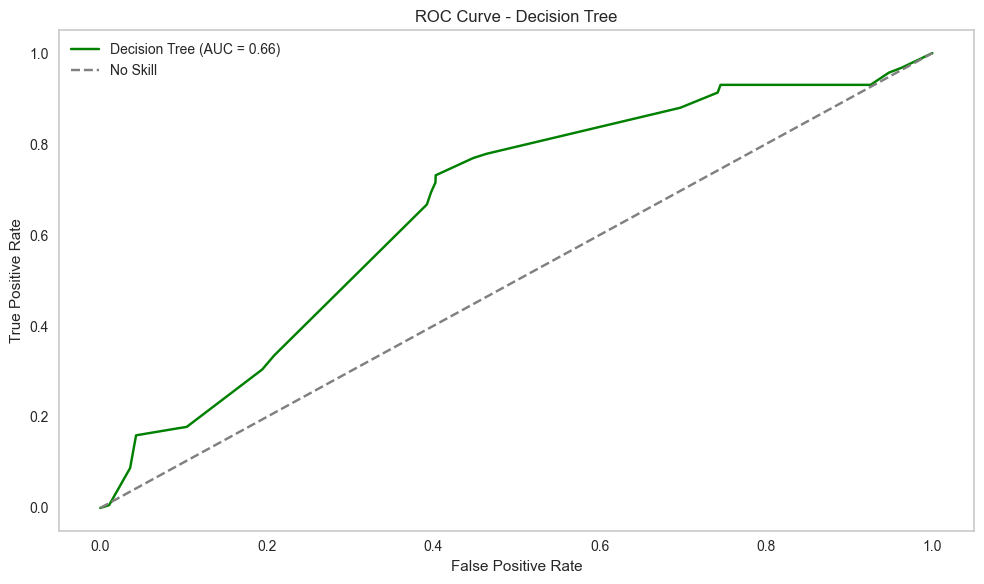

Random Forest Metrics:
F1-Score: 0.7236
Accuracy: 0.7257
Precision: 0.7226
Recall: 0.7257

Classification Report for Random Forest:
              precision    recall  f1-score   support

    Inactive       0.77      0.80      0.78      3205
      Active       0.65      0.60      0.62      1947

    accuracy                           0.73      5152
   macro avg       0.71      0.70      0.70      5152
weighted avg       0.72      0.73      0.72      5152



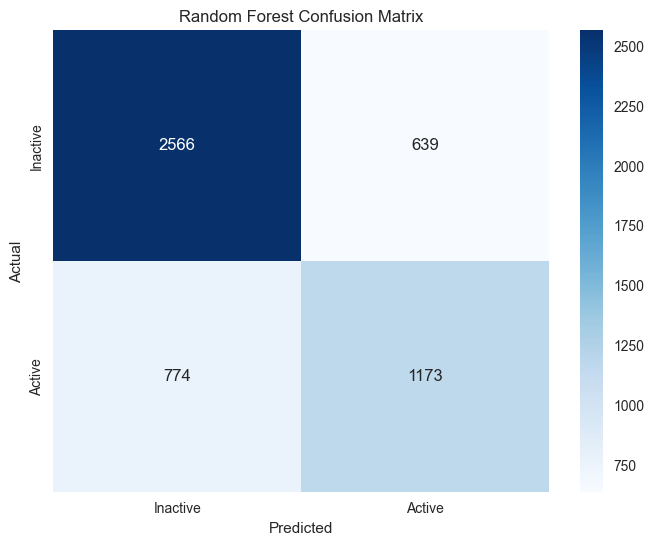

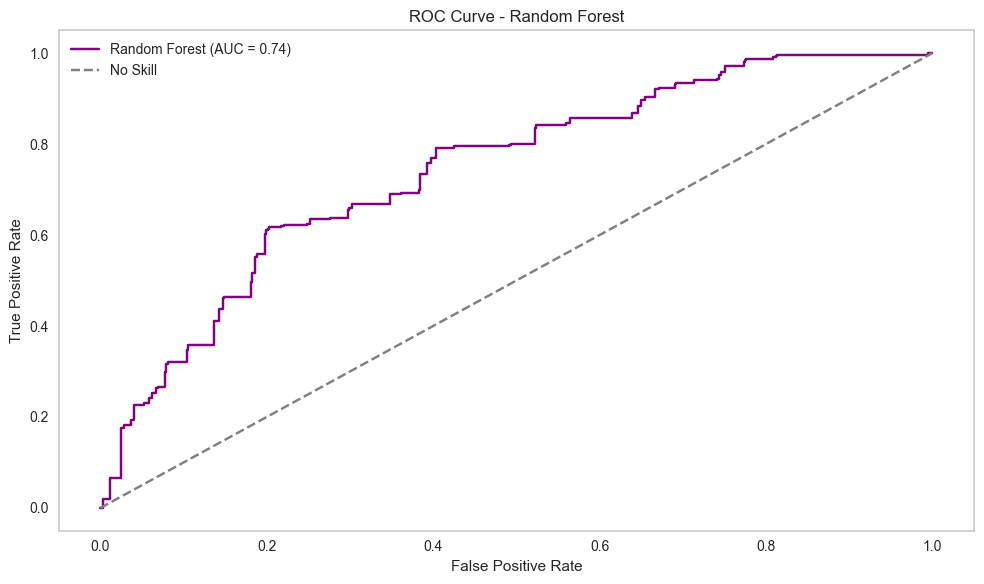

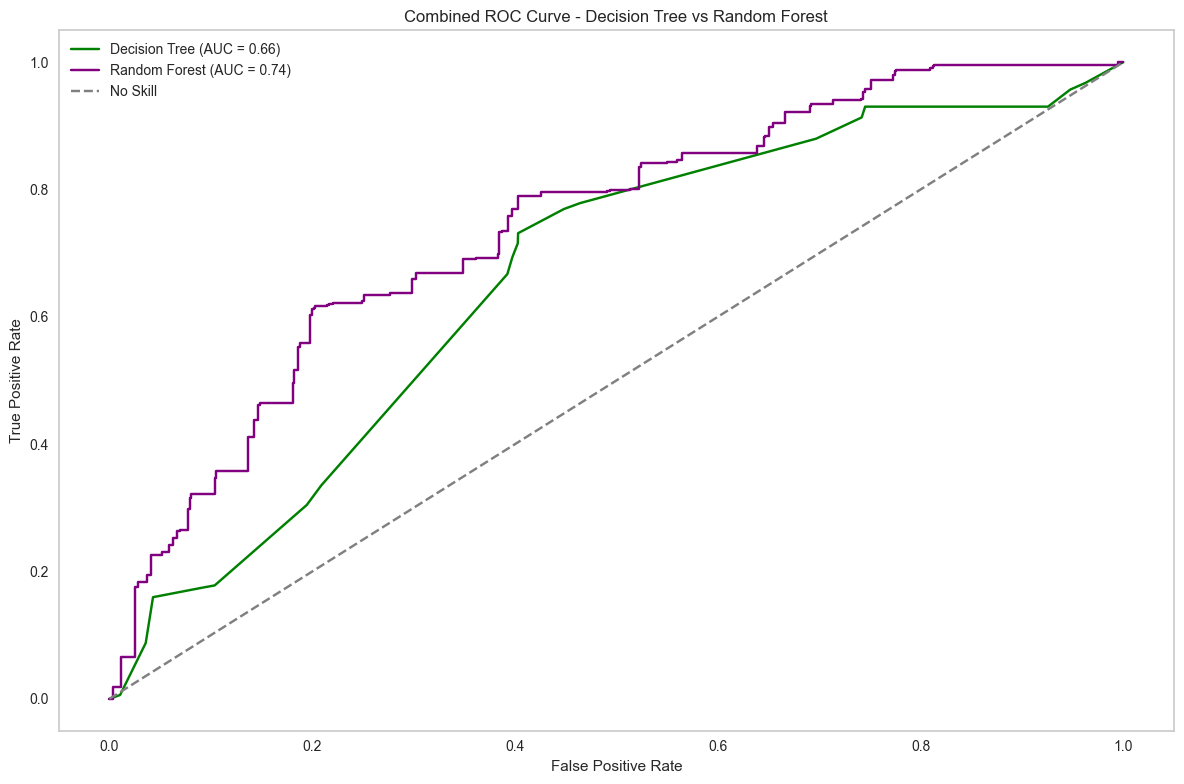

In [50]:
# Decision Tree
y_pred_dt = dt_best_grid_model.predict(X_test_dt)  # Predictions using the best Decision Tree model from GridSearch

# Calculate metrics for Decision Tree
dt_test_f1 = f1_score(y_test, y_pred_dt, average='weighted')
dt_test_accuracy = accuracy_score(y_test, y_pred_dt)
dt_test_precision = precision_score(y_test, y_pred_dt, average='weighted')
dt_test_recall = recall_score(y_test, y_pred_dt, average='weighted')

# Print Decision Tree metrics
print("Decision Tree Metrics:")
print(f"F1-Score: {dt_test_f1:.4f}")
print(f"Accuracy: {dt_test_accuracy:.4f}")
print(f"Precision: {dt_test_precision:.4f}")
print(f"Recall: {dt_test_recall:.4f}")

# Classification Report and Confusion Matrix for Decision Tree
print("\nClassification Report for Decision Tree:")
print(classification_report(y_test, y_pred_dt, target_names=['Inactive', 'Active']))
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

# Confusion Matrix Visualization for Decision Tree
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Inactive', 'Active'], yticklabels=['Inactive', 'Active'])
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve for Decision Tree
dt_probs = dt_best_grid_model.predict_proba(X_test_dt)[:, 1]
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)
dt_auc = auc(dt_fpr, dt_tpr)

plt.figure(figsize=(10, 6))
plt.plot(dt_fpr, dt_tpr, label=f"Decision Tree (AUC = {dt_auc:.2f})", color="green")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="No Skill")
plt.title("ROC Curve - Decision Tree")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Random Forest
y_pred_rf = rf_best_grid_model.predict(X_test_rf)  # Predictions using the best Random Forest model from GridSearch

# Calculate metrics for Random Forest
rf_test_f1 = f1_score(y_test, y_pred_rf, average='weighted')
rf_test_accuracy = accuracy_score(y_test, y_pred_rf)
rf_test_precision = precision_score(y_test, y_pred_rf, average='weighted')
rf_test_recall = recall_score(y_test, y_pred_rf, average='weighted')

# Print Random Forest metrics
print("Random Forest Metrics:")
print(f"F1-Score: {rf_test_f1:.4f}")
print(f"Accuracy: {rf_test_accuracy:.4f}")
print(f"Precision: {rf_test_precision:.4f}")
print(f"Recall: {rf_test_recall:.4f}")

# Classification Report and Confusion Matrix for Random Forest
print("\nClassification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=['Inactive', 'Active']))
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Confusion Matrix Visualization for Random Forest
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Inactive', 'Active'], yticklabels=['Inactive', 'Active'])
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve for Random Forest
rfc_probs = rf_best_grid_model.predict_proba(X_test_rf)[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rfc_probs)
rf_auc = auc(rf_fpr, rf_tpr)

plt.figure(figsize=(10, 6))
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {rf_auc:.2f})", color="purple")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="No Skill")
plt.title("ROC Curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Combined ROC Curve for Decision Tree and Random Forest
plt.figure(figsize=(12, 8))
plt.plot(dt_fpr, dt_tpr, label=f"Decision Tree (AUC = {dt_auc:.2f})", color="green")
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {rf_auc:.2f})", color="purple")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="No Skill")
plt.title("Combined ROC Curve - Decision Tree vs Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### **5.3.7 Performance comparison** of results for Decision Tree and Random Forest models

#### **Decision Tree** Model
The Decision Tree model showed significant improvements in all metrics after hyperparameter tuning. The percentage changes are computed as follows:

* **Accuracy**: Increased from 55.34% to 64.19% (+15.98%).
* **F1-Score**: Improved from 0.5600 to 0.6471 (+15.91%).
* **Precision**: Increased from 58.73% to 67.86% (+15.55%).
* **Recall**: Improved from 55.34% to 64.19% (+15.98%).

**Class-Specific Metrics**:
* For the `Inactive` class:
  - Precision increased from 68% to 78% (+14.71%).
  - Recall improved slightly from 53% to 60% (+13.21%).

* For the `Active` class:
  - Precision increased from 43% to 52% (+20.93%).
  - Recall improved significantly from 59% to 72% (+22.03%).

**Misclassifications**:
* For the `Inactive` class:
  - False positives decreased from 1503 to 1291, a reduction of 14.11%.
* For the `Active` class:
  - False negatives dropped from 798 to 554, a reduction of 30.57%.

The most significant improvements for the Decision Tree model were in the `Active` class metrics, with recall increasing by 22.03% and false negatives reducing by 30.57%, indicating much better detection of `Active` instances.

#### **Random Forest** Model
The Random Forest model also showed considerable improvement after tuning. The percentage changes are computed as follows:

* **Accuracy**: Increased from 68.05% to 72.57% (+6.64%).
* **F1-Score**: Improved from 0.6752 to 0.7236 (+7.17%).
* **Precision**: Increased from 67.36% to 72.26% (+7.26%).
* **Recall**: Improved from 68.05% to 72.57% (+6.64%).

**Class-Specific Metrics**:
* For the `Inactive` class:
  - Precision remained stable, decreasing slightly from 72% to 77% (+6.94%).
  - Recall improved from 78% to 80% (+2.56%).

* For the `Active` class:
  - Precision increased from 59% to 65% (+10.17%).
  - Recall improved from 51% to 60% (+17.65%).

**Misclassifications**:
* For the `Inactive` class:
  - False positives decreased from 691 to 639, a reduction of 7.53%.
* For the `Active` class:
  - False negatives dropped from 955 to 774, a reduction of 18.94%.

The most significant improvements for the Random Forest model were in the `Active` class metrics, with recall increasing by 17.65% and false negatives reducing by 18.94%, indicating better performance in detecting `Active` instances.

#### **Conclusions**
* The **Decision Tree** model showed larger percentage improvements overall, particularly in detecting `Active` instances, with recall increasing by 22.03% and false negatives reducing by 30.57%.
* However, the **Random Forest** model maintained its superior overall performance, with higher accuracy and better balance across both classes.

Hyperparameter tuning resulted in notable gains for both models, highlighting the value of this optimization step for improving predictive performance.

## **5.4 Light Gradient Boosting Machine**


### **5.4.1 Run Model without any optimization**

In [51]:
# Define the model (based on RandomizedSearch parameters because they give us a better result)
lgbm = lgb.LGBMClassifier(boosting_type= 'gbdt')

# Train the model
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 7428, number of negative: 8164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2333
[LightGBM] [Info] Number of data points in the train set: 15592, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476398 -> initscore=-0.094478
[LightGBM] [Info] Start training from score -0.094478


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=None, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

### **5.4.2 Model Evaluation with Report, Confusion Matrix, Feature Relevance and ROC-Curve**

Validation Accuracy of the manually trained LightGBM model: 0.6653726708074534
F1-Score: 0.6536
Precision: 0.6538
Recall: 0.6654
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.81      0.75      3205
           1       0.58      0.44      0.50      1947

    accuracy                           0.67      5152
   macro avg       0.64      0.62      0.62      5152
weighted avg       0.65      0.67      0.65      5152



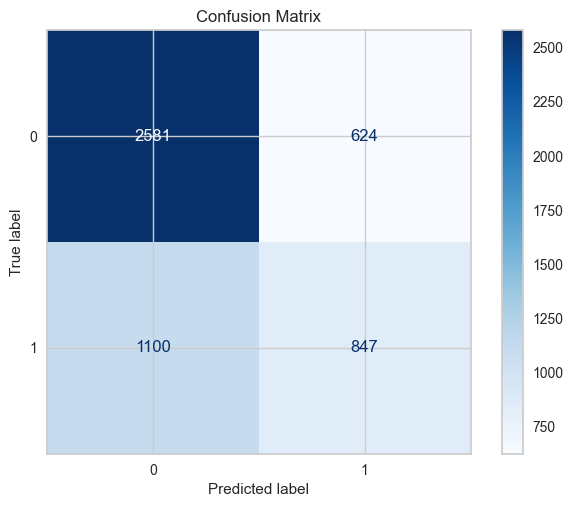

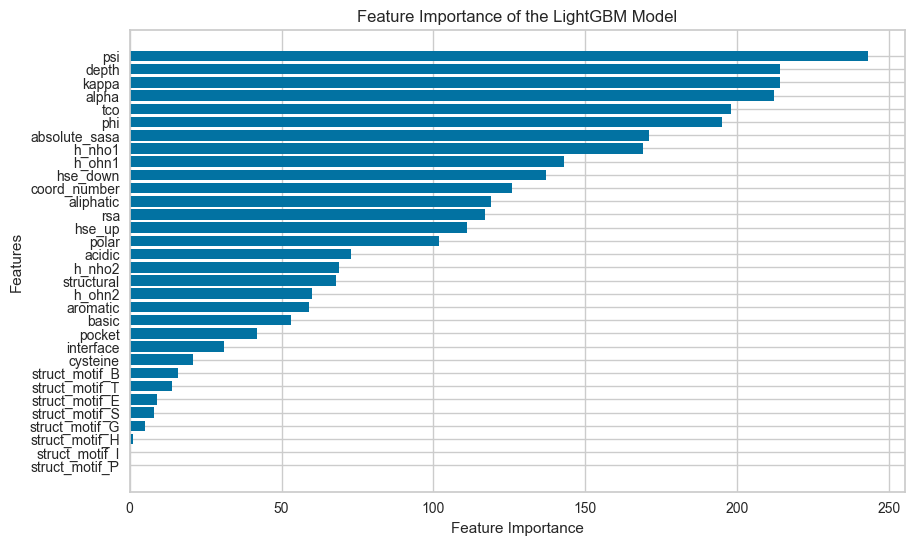

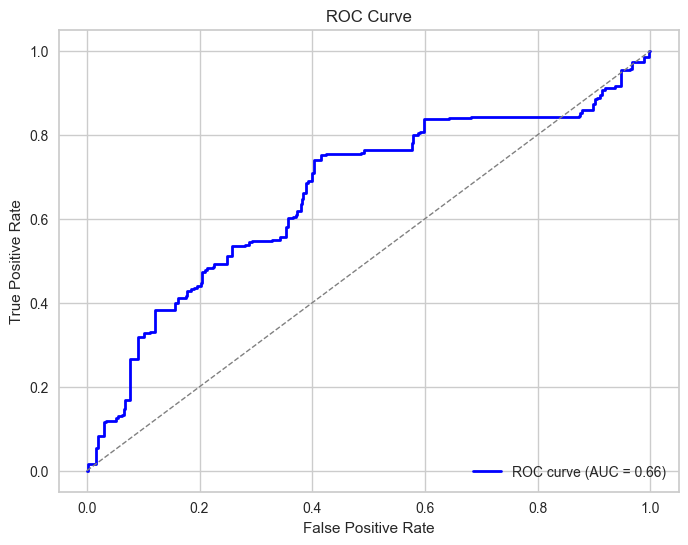

In [52]:
# Accuracy and classification report
y_pred = lgbm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' für unbalancierte Daten
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print("Validation Accuracy of the manually trained LightGBM model:", accuracy)
print(f"F1-Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))


# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgbm.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Feature Importance
feature_importances = lgbm.feature_importances_
features = X_test.columns
# Sort feature importances
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_features = features[sorted_idx]
sorted_importances = feature_importances[sorted_idx]
# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance of the LightGBM Model')
plt.gca().invert_yaxis()
plt.show()

# ROC Curve
y_pred_proba = lgbm.predict_proba(X_test)[:, 1]  # Probabilities for positive class
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)  # Adjust `pos_label` as needed
roc_auc = auc(fpr, tpr)
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### **5.4.3 Find best parameters with GridSearchCV and RandomizedSearchCV**
We test some common values for each of the parameters used to train the model.

GridSearchCV

In [53]:
# Define the LightGBM classifier
lgbm = lgb.LGBMClassifier(random_state=123)

# Define parameter grid for optimization
param_grid = {
    'num_leaves': [50, 100],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [-1, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}


# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=lgbm,
                           param_grid=param_grid,
                           cv=3,  # 3-fold cross-validation
                           scoring='accuracy',  # Metric to optimize
                           verbose=2,  # Display progress
                           n_jobs=-1)  # Use all available cores

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_score_ = grid_search.best_score_
print("Best Parameters from GridSearch:", best_params)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[LightGBM] [Info] Number of positive: 4952, number of negative: 5443
[LightGBM] [Info] Number of positive: 4952, number of negative: 5442
[LightGBM] [Info] Number of positive: 4952, number of negative: 5443
[LightGBM] [Info] Number of positive: 4952, number of negative: 5443
[LightGBM] [Info] Number of positive: 4952, number of negative: 5442
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2256
[LightGBM] [Info] Number of data points in the train set: 10394, number of used features: 32
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2250
[LightGBM] [Info] [binary:BoostFromScore]: p

RandomizedSearchCV

In [54]:
# Define the LightGBM classifier
lgbm = lgb.LGBMClassifier(random_state=123)

# Define parameter grid for optimization
param_distributions = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'max_depth': [-1, 10, 20],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_distributions,
    n_iter=20,  # Number of random parameter combinations to try
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',  # Metric to optimize
    verbose=2,  # Display progress
    n_jobs=-1,  # Use all available cores
    random_state=123  # Ensure reproducibility
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_params = random_search.best_params_
best_score_ = random_search.best_score_
print("Best Parameters from RandomizedSearch:", best_params)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 4952, number of negative: 5442
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2256
[LightGBM] [Info] Number of data points in the train set: 10394, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476429 -> initscore=-0.094355
[LightGBM] [Info] Start training from score -0.094355
[LightGBM] [Info] Number of positive: 4952, number of negative: 5443
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2261
[LightGBM] [Info] Number of data points in the train s

### **5.4.4 Manually train model with best parameters (so time-consuming GridSearch/RandomizedSearch doesn't have to be run every time)**

In [55]:
# Define the model (based on RandomizedSearch parameters because they give us a better result)
lgbm = lgb.LGBMClassifier(boosting_type= 'gbdt',
                          colsample_bytree= 1,
                          learning_rate= 0.1,
                          max_depth= -1,
                          n_estimators= 100,
                          num_leaves= 100,
                          subsample= 0.8)

# Train the model
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 7428, number of negative: 8164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2333
[LightGBM] [Info] Number of data points in the train set: 15592, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476398 -> initscore=-0.094478
[LightGBM] [Info] Start training from score -0.094478


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=None, num_leaves=100, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8,
               subsample_for_bin=200000, subsample_freq=0)

### **5.4.5 Model Evaluation with Report, Confusion Matrix, Feature Relevance and ROC-Curve**

Validation Accuracy of the manually trained LightGBM model: 0.671972049689441
F1-Score: 0.6708
Precision: 0.6699
Recall: 0.6720
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.75      0.74      3205
           1       0.57      0.55      0.56      1947

    accuracy                           0.67      5152
   macro avg       0.65      0.65      0.65      5152
weighted avg       0.67      0.67      0.67      5152



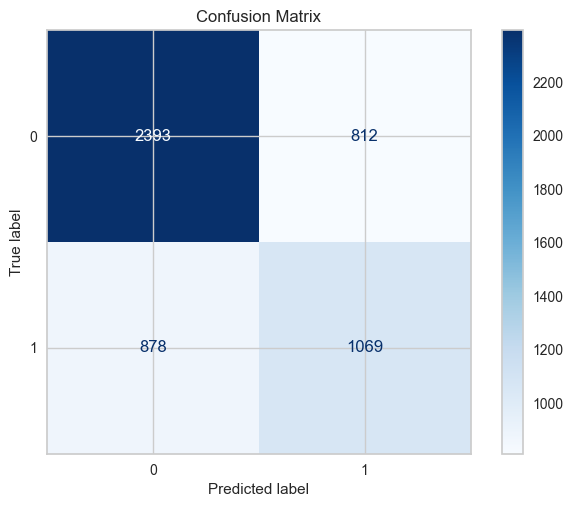

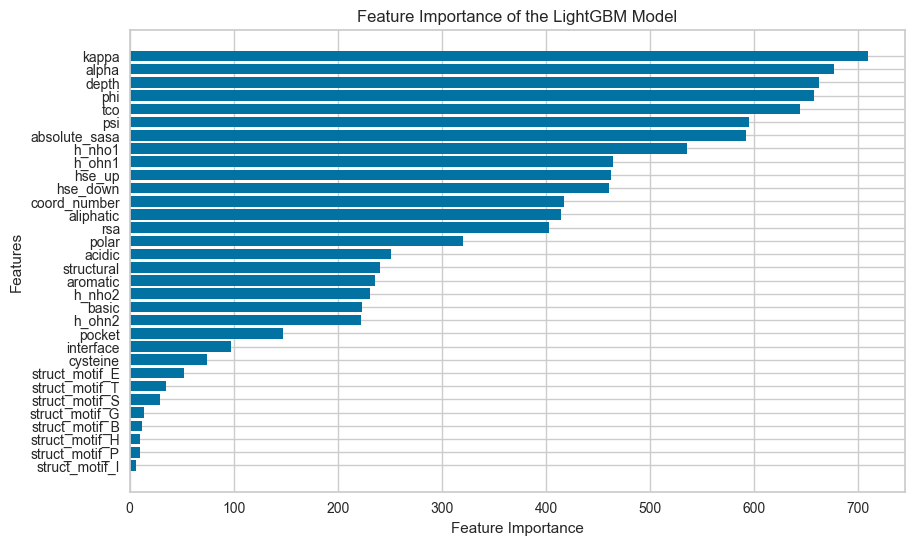

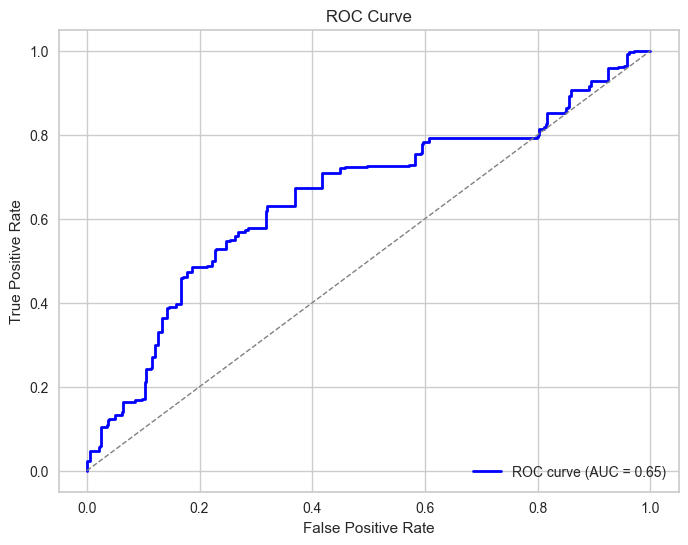

In [56]:
# Accuracy and classification report
y_pred = lgbm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' für unbalancierte Daten
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print("Validation Accuracy of the manually trained LightGBM model:", accuracy)
print(f"F1-Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))


# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgbm.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Feature Importance
feature_importances = lgbm.feature_importances_
features = X_test.columns
# Sort feature importances
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_features = features[sorted_idx]
sorted_importances = feature_importances[sorted_idx]
# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance of the LightGBM Model')
plt.gca().invert_yaxis()
plt.show()

# ROC Curve
y_pred_proba = lgbm.predict_proba(X_test)[:, 1]  # Probabilities for positive class
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)  # Adjust `pos_label` as needed
roc_auc = auc(fpr, tpr)
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

**Commentary on Results**

1. **Accuracy**:
   - Initial: 0.66
   - Final: 0.67
   - **Change**: Increase of **1.5%**
   - **Explanation**: The increase in testing F1-score highlights that the tuned model now performs better at balancing precision and recall on unseen data.

2. **F1-Score**:
   - Initial: 0.65
   - Final: 0.67
   - **Change**: Increase of **3%**
   - **Explanation**: The testing accuracy improved, demonstrating better generalization after tuning.



### 5.4.6 Re-train and optimize and evaluate model with excluded features (no better performance, therefore no specific split into sub-chapters)
We test if the model performs better when excluding features with very low importance based on the feature importance analysis.

In [57]:
# Exclude features
X_train_reduced = X_train.drop(columns=['struct_motif_I','struct_motif_P','struct_motif_H','struct_motif_B','struct_motif_G','struct_motif_S','struct_motif_E','struct_motif_T','cysteine' , 'interface'])
X_test_reduced = X_test.drop(columns=['struct_motif_I','struct_motif_P','struct_motif_H','struct_motif_B','struct_motif_G','struct_motif_S','struct_motif_E','struct_motif_T','cysteine' , 'interface'])

# Fit RandomizedSearchCV
random_search.fit(X_train_reduced, y_train)

# Get the best parameters and the best estimator
best_params = random_search.best_params_
best_score_ = random_search.best_score_
print("Best Parameters from RandomizedSearch:", best_params)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 4952, number of negative: 5442
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2227
[LightGBM] [Info] Number of data points in the train set: 10394, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476429 -> initscore=-0.094355
[LightGBM] [Info] Start training from score -0.094355
[LightGBM] [Info] Number of positive: 4952, number of negative: 5443
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train s

In [58]:
# Manually train model
lgbm = lgb.LGBMClassifier(boosting_type= 'gbdt',
                          colsample_bytree= 0.8,
                          learning_rate= 0.01,
                          max_depth= -1,
                          n_estimators= 200,
                          num_leaves= 100,
                          subsample= 1.0)
lgbm.fit(X_train_reduced, y_train)

[LightGBM] [Info] Number of positive: 7428, number of negative: 8164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2304
[LightGBM] [Info] Number of data points in the train set: 15592, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476398 -> initscore=-0.094478
[LightGBM] [Info] Start training from score -0.094478


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=None, num_leaves=100, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

Validation Accuracy of the manually trained LightGBM model: 0.6756599378881988
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.73      0.74      3205
           1       0.57      0.58      0.58      1947

    accuracy                           0.68      5152
   macro avg       0.66      0.66      0.66      5152
weighted avg       0.68      0.68      0.68      5152



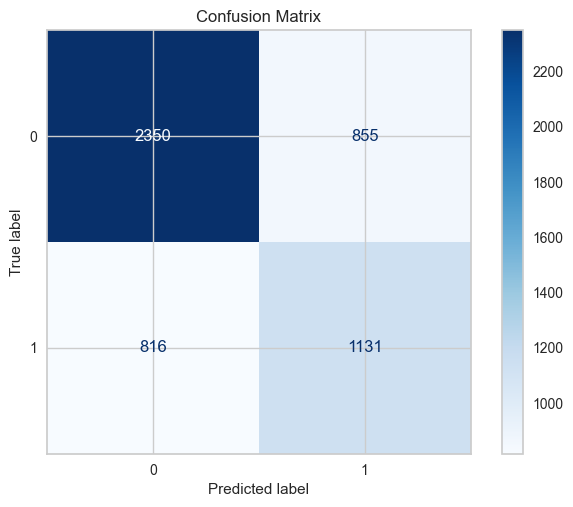

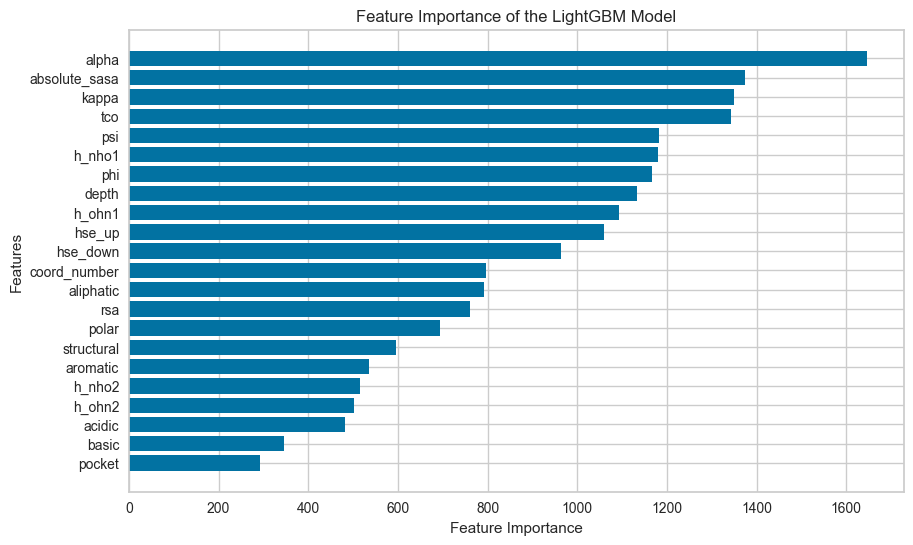

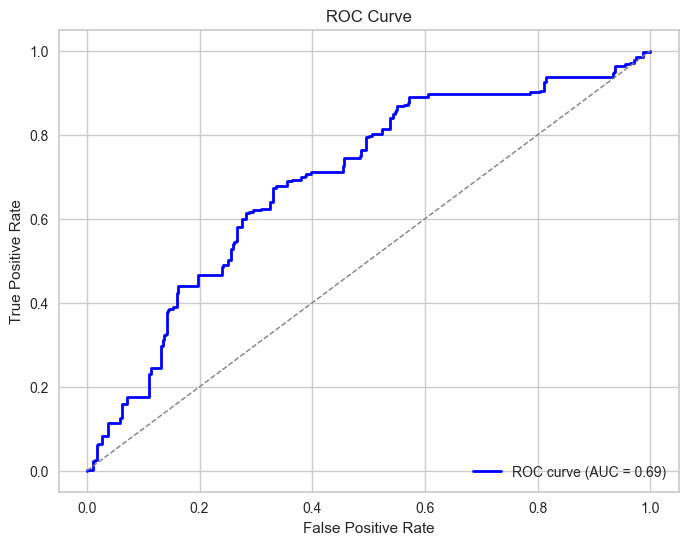

In [59]:
# Evaluate on the validation set
y_pred = lgbm.predict(X_test_reduced)
accuracy = accuracy_score(y_test, y_pred)
print("Validation Accuracy of the manually trained LightGBM model:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))


# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgbm.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Feature Importance
feature_importances = lgbm.feature_importances_
features = X_test_reduced.columns
# Sort feature importances
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_features = features[sorted_idx]
sorted_importances = feature_importances[sorted_idx]
# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance of the LightGBM Model')
plt.gca().invert_yaxis()
plt.show()

# ROC Curve
y_pred_proba = lgbm.predict_proba(X_test_reduced)[:, 1]  # Probabilities for positive class
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)  # Adjust `pos_label` as needed
roc_auc = auc(fpr, tpr)
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## **5.5 Extra Trees Classifier**

### 5.5.1 Determine which columns we exclude and define features and label for the model

This section identifies which columns to exclude from the dataset because they are not relevant for model training or could cause data leakage. These columns include unique identifiers (e.g., 'uniprot_accession', 'pdb_id'), descriptive names (e.g., 'entry_name', 'gene_names'), and the target label ('is_active'). The remaining columns are used as input features for the model. The dataset is then split into training and testing sets, with 'is_active' used as the target variable for both.

In [60]:
columns_to_drop = ['uniprot_accession', 'pdb_id', 'entry_name', 'gene_names',
                   'protein_names', 'is_active', 'ligand_name', 'ligand_smiles', 'residue_number']

X_train_et = train_df.drop(columns=columns_to_drop)
y_train_et = train_df['is_active']

X_test_et = test_df.drop(columns=columns_to_drop)
y_test_et = test_df['is_active']

### 5.5.2 Building the initial Extra Tree Classifier

This section builds an initial Extra Trees Classifier to evaluate its performance. First, the classifier is initialized with a fixed random state for reproducibility. The model is trained using the training features and labels. Predictions are then made on the test set, and performance metrics such as accuracy, F1-score, precision, and recall are calculated using a weighted average to handle class imbalance. These metrics, along with a detailed classification report, are printed to assess the model's validation performance.

In [61]:
et_model = ExtraTreesClassifier(random_state=42)

et_model.fit(X_train_et, y_train_et)

y_test_initial_pred = et_model.predict(X_test_et)

et_accuracy = accuracy_score(y_test_et, y_test_initial_pred)
et_f1 = f1_score(y_test_et, y_test_initial_pred, average='weighted')
et_precision = precision_score(y_test_et, y_test_initial_pred, average='weighted')
et_recall = recall_score(y_test_et, y_test_initial_pred, average='weighted')
print("Validation Accuracy of the manually trained Extra Tress Classifier:", et_accuracy)
print(f"F1-Score: {et_f1:.4f}")
print(f"Precision: {et_precision:.4f}")
print(f"Recall: {et_recall:.4f}")
print("Classification Report:\n", classification_report(y_test_et, y_test_initial_pred))

Validation Accuracy of the manually trained Extra Tress Classifier: 0.7137034161490683
F1-Score: 0.7064
Precision: 0.7070
Recall: 0.7137
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.83      0.78      3205
           1       0.65      0.52      0.58      1947

    accuracy                           0.71      5152
   macro avg       0.70      0.68      0.68      5152
weighted avg       0.71      0.71      0.71      5152



### 5.5.3 Confusion Matrix before tuning

The confusion matrix summarizes the initial model's prediction performance by showing the counts of true positives, true negatives, false positives, and false negatives.

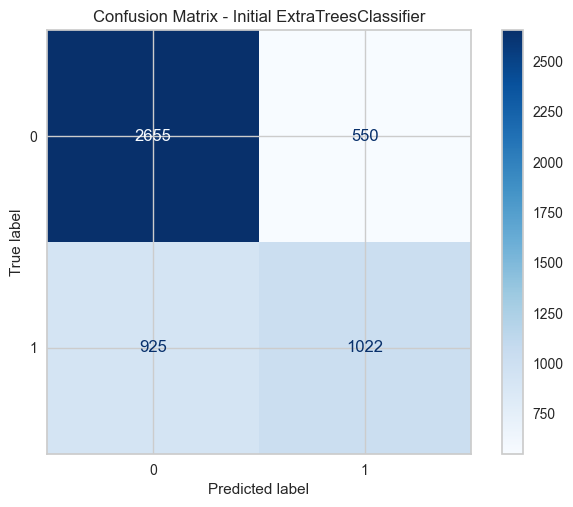

In [62]:
initial_cm = confusion_matrix(y_test_et, y_test_initial_pred)

initial_disp = ConfusionMatrixDisplay(confusion_matrix=initial_cm, display_labels=et_model.classes_)
initial_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Initial ExtraTreesClassifier")
plt.show()

### 5.5.4 Using RandomizedSearchCV for the Extra Tree Classifier

In this section, a more robust Extra Trees Classifier is built using hyperparameter tuning with RandomizedSearchCV. A parameter grid is defined to explore various combinations of model settings, such as the number of estimators, maximum tree depth, and splitting criteria. Stratified k-fold cross-validation ensures a balanced evaluation across different folds. The RandomizedSearchCV method performs randomized sampling of parameter combinations to identify the best configuration within the specified number of iterations. After fitting the model, the best estimator is selected and evaluated on the test set. Key performance metrics, along with the best hyperparameters, are printed for analysis.

In [63]:
et_model = ExtraTreesClassifier(random_state=42)

et_cv_splitter = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

et_param_grid = {
    'n_estimators': [5, 10, 50, 100],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [False, True]
}

et_random_search = RandomizedSearchCV(
    estimator=et_model,
    param_distributions=et_param_grid,
    n_iter=50,
    cv=et_cv_splitter,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

et_random_search.fit(X_train_et, y_train_et)

best_et_model = et_random_search.best_estimator_

# Evaluate the best model on the validation set
y_test_pred = best_et_model.predict(X_test_et)

print("Best Parameters:", et_random_search.best_params_)
print("Validation Accuracy:", accuracy_score(y_test_et, y_test_pred))
print("Classification Report:")
print(classification_report(y_test_et, y_test_pred))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total tim

### 5.5.5 Using GridSearchCV around the found parameters for the Extra Tree Classifier

In this section, the Extra Trees Classifier is further refined using GridSearchCV. A refined parameter grid is created based on the best parameters found during the previous randomized search, narrowing the search range to optimize performance. The grid includes slightly adjusted values for key parameters such as the number of estimators, maximum tree depth, and minimum sample splits. A grid search is then performed using cross-validation to identify the optimal combination of parameters. After fitting the refined model, its performance is evaluated on the test set, and metrics such as accuracy, F1-score, precision, and recall are calculated and displayed. The results provide a detailed evaluation of the final optimized model.

In [64]:
et_refined_param_grid = {
    'n_estimators': [
        best_et_model.get_params()['n_estimators'] - 10,
        best_et_model.get_params()['n_estimators'],
        best_et_model.get_params()['n_estimators'] + 10
    ],
    'max_depth': [
        max(1, best_et_model.get_params()['max_depth'] - 1) if best_et_model.get_params()['max_depth'] else None,
        best_et_model.get_params()['max_depth'],
        best_et_model.get_params()['max_depth'] + 1 if best_et_model.get_params()['max_depth'] else 10
    ],
    'min_samples_split': [
        max(2, best_et_model.get_params()['min_samples_split'] - 1),
        best_et_model.get_params()['min_samples_split'],
        best_et_model.get_params()['min_samples_split'] + 1
    ],
    'min_samples_leaf': [
        max(1, best_et_model.get_params()['min_samples_leaf'] - 1),
        best_et_model.get_params()['min_samples_leaf'],
        best_et_model.get_params()['min_samples_leaf'] + 1
    ],
    'max_features': [best_et_model.get_params()['max_features']],
    'bootstrap': [best_et_model.get_params()['bootstrap']]
}


# Perform Grid Search
et_grid_search = GridSearchCV(
    estimator=et_model,
    param_grid=et_refined_param_grid,
    cv=et_cv_splitter,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Fit Grid Search on the training data
et_grid_search.fit(X_train_et, y_train_et)

# Get the best model from Grid Search
final_best_et_model = et_grid_search.best_estimator_

# Evaluate the final model on the test set
y_test_pred_final = final_best_et_model.predict(X_test_et)

final_et_accuracy = accuracy_score(y_test_et, y_test_pred_final)
final_et_f1 = f1_score(y_test_et, y_test_pred_final, average='weighted')
final_et_precision = precision_score(y_test_et, y_test_pred_final, average='weighted')
final_et_recall = recall_score(y_test_et, y_test_pred_final, average='weighted')

# Print the evaluation results
print("Validation Accuracy of the final Extra Trees Classifier:", final_et_accuracy)
print(f"F1-Score: {final_et_f1:.4f}")
print(f"Precision: {final_et_precision:.4f}")
print(f"Recall: {final_et_recall:.4f}")
print("Classification Report:\n", classification_report(y_test_et, y_test_pred_final))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=90; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=90; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=90; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_est

### 5.5.6 Confusion matrix of the tuned Extra Tree Classifier

This section visualizes the confusion matrix for the tuned Extra Trees Classifier. The confusion matrix is generated to compare the true labels with the predictions made by the final, optimized model.

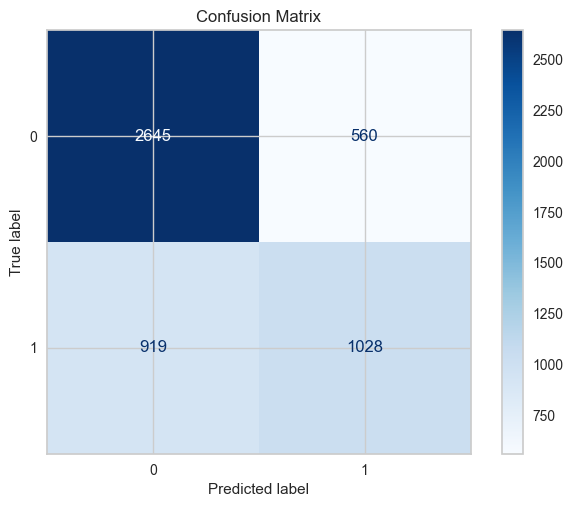

In [65]:
et_cm = confusion_matrix(y_test_et, y_test_pred_final)

et_disp = ConfusionMatrixDisplay(confusion_matrix=et_cm, display_labels=final_best_et_model.classes_)
et_disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

### 5.5.7 Feature importance of the final Extra Tree Classifier

The importance of each feature is extracted from the trained model and paired with the corresponding feature names. These values are organized into a DataFrame and sorted in ascending order based on their importance scores. A bar plot is then created to visualize the contribution of each feature to the model's predictions, making it easier to identify the most and least influential features.

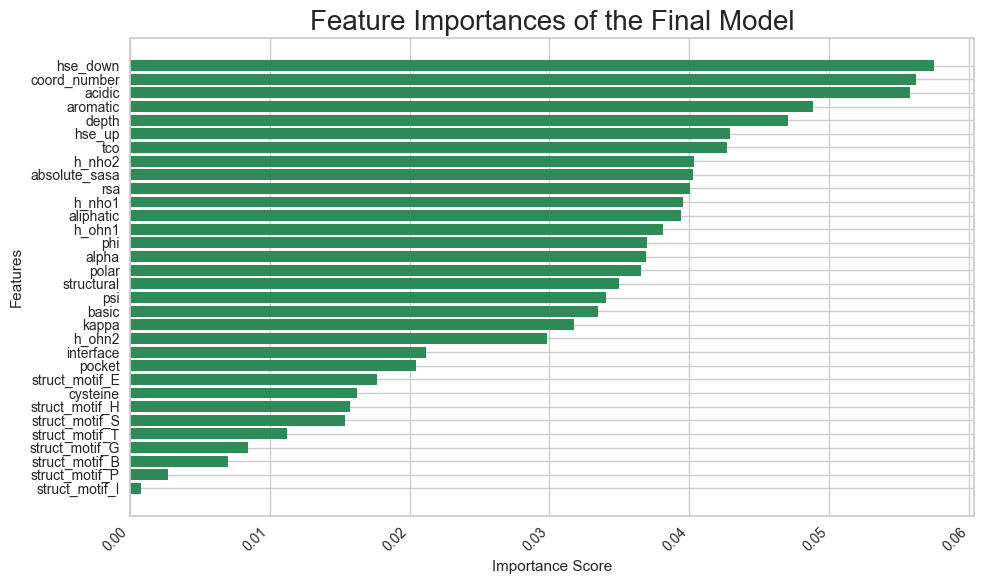

In [66]:
feature_importances = final_best_et_model.feature_importances_

feature_names = X_test_et.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='seagreen')
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importances of the Final Model", fontsize=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

### 5.5.8 Calculate ROC Curve and AUC Score

This section calculates and visualizes the Receiver Operating Characteristic (ROC) curve and Area Under the Curve (AUC) score for the final Extra Trees Classifier. The model's predicted probabilities are used to compute the true positive rate (TPR) and false positive rate (FPR) at various thresholds. These values are then plotted to form the ROC curve, with the AUC score providing a single-value summary of the model's discriminatory ability.

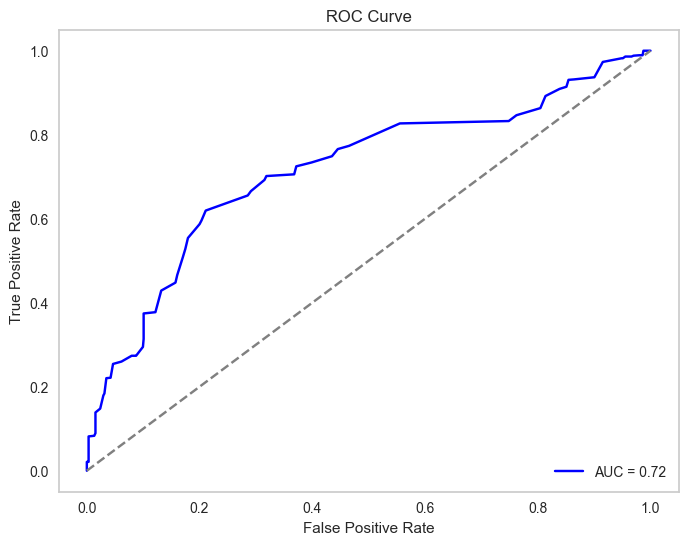

In [67]:
y_test_pred_proba_et = final_best_et_model.predict_proba(X_test_et)[:, 1]
et_fpr, et_tpr, et_thresholds = roc_curve(y_test_et, y_test_pred_proba_et)
et_roc_auc = roc_auc_score(y_test_et, y_test_pred_proba_et)

plt.figure(figsize=(8, 6))
plt.plot(et_fpr, et_tpr, color='blue', label=f"AUC = {et_roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# **6. Deep Learning Model (ANN)**


This code implements an Artificial Neural Network (ANN) for multi-class classification, leveraging Keras with a TensorFlow backend.

*It is important to note that due to the nature of an ANN model and the tuning methods used, such as dropout, which randomly drops a neuron each time the code is run, different results will be obtained each time the code is run.  However, the tests were run several times and the results presented in the text are those that we obtained on average.*

In the code:

**One-Hot Encoding**: The target labels `y_train` are one-hot encoded to transform them into a format suitable for classification. This ensures that each label is represented as a binary vector indicating the class.

**Network Architecture**: The model is composed of several fully connected layers. The first two layers are Dense layers, each followed by a Dropout layer to reduce overfitting. The final output layer uses the Softmax activation function to produce class probabilities, making it suitable for multi-class classification tasks.

**Activation Functions**: The hidden layers use the ReLU (Rectified Linear Unit) activation function, which introduces non-linearity into the network, allowing it to learn more complex patterns in the data.

**Regularization**: The Dropout layers (with a rate of 30%) are included to prevent overfitting by randomly setting a fraction of the input units to zero during training.

**Compilation and Training**: The model is compiled using the Adam optimizer and categorical cross-entropy loss, both standard choices for multi-class classification problems. The model is then trained for 50 epochs using batches of 32 samples, and the performance is evaluated with accuracy as the primary metric.

**Evaluation**: After training, the model’s predictions are compared with the test labels using accuracy, a detailed classification report (precision, recall, F1-score), and a confusion matrix.

In [68]:
# Ensure y_train is one-hot encoded
y_train_categorical = to_categorical(y_train, num_classes=len(np.unique(y_train)))

# Define the model
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(y_train_categorical.shape[1], activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_categorical, epochs=50, batch_size=32, verbose=1)

# Make predictions on the test set
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)


y_test_classes = y_test

# Calculate accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print("Accuracy:", accuracy)

# Detailed classification report
print("Classification Report:\n", classification_report(y_test_classes, y_pred_classes))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test_classes, y_pred_classes))

Epoch 1/50
488/488 ━━━━━━━━━━━━━━━━━━━━ 1s 576us/step - accuracy: 0.6161 - loss: 0.6375
Epoch 2/50
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - accuracy: 0.7850 - loss: 0.4458
Epoch 3/50
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - accuracy: 0.8279 - loss: 0.3846
Epoch 4/50
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.8524 - loss: 0.3351
Epoch 5/50
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - accuracy: 0.8683 - loss: 0.3078
Epoch 6/50
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - accuracy: 0.8806 - loss: 0.2853
Epoch 7/50
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - accuracy: 0.8946 - loss: 0.2724
Epoch 8/50
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - accuracy: 0.8981 - loss: 0.2504
Epoch 9/50
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - accuracy: 0.9124 - loss: 0.2323
Epoch 10/50
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - accuracy: 0.9146 - loss: 0.2221
Epoch 11/50
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - accuracy: 0.9169 - loss: 0.2131
Epoch 12/50
488/488 ━━━━━━━━━━

**Accuracy:**

The overall accuracy of the model is **64.89%**. This means that approximately 65% of the test samples were correctly classified. While this accuracy is moderately reasonable, there remains room for improvement.


**Classification Report:**

The classification report provides detailed metrics for each class, including precision, recall, and F1-score.

**Class 0 (label 0):**

**Precision (0.75):** The model correctly predicted 75% of all instances that were predicted as class 0.

**Recall (0.65):** The model correctly identified 65% of all actual class 0 instances.

**F1-score (0.70):** The harmonic mean of precision and recall is 0.70, reflecting a balance between the two metrics for class 0.

**Class 1 (label 1):**

**Precision (0.53):** The model correctly predicted 53% of instances predicted as class 1.

**Recall (0.65):** The model correctly identified 65% of all actual class 1 instances.

**F1-score (0.58):** The F1-score for class 1 is 0.58, which is lower than for class 0, indicating that the model struggles more with class 1.


**Macro Average:**

The macro average calculates the unweighted average of the precision, recall, and F1-scores across all classes. Here, the macro averages for precision, recall, and F1-score are all approximately **0.64**, indicating a relatively balanced but not exceptional performance across both classes.


**Weighted Average:**

The weighted average takes into account the number of samples in each class (support). For this dataset, the weighted averages for precision, recall, and F1-score are all **0.65**, showing a slight improvement when factoring in the class imbalance.


**Confusion Matrix:**

The confusion matrix provides a detailed look at how the model performed for each class:

- **True positives (TP):**
  - 2070 instances of class 0 were correctly predicted as class 0.
  - 1273 instances of class 1 were correctly predicted as class 1.

- **False positives (FP):**
  - 1135 instances were incorrectly predicted as class 0 when they were actually class 1.

- **False negatives (FN):**
  - 674 instances were incorrectly predicted as class 1 when they were actually class 0.

The confusion matrix highlights that the model is better at correctly classifying class 0, with a higher true positive count (2070) compared to class 1 (1273). However, it also reveals a significant number of misclassifications for both classes, particularly for class 1, which affects the overall recall and precision metrics.


The model demonstrates moderate performance, particularly excelling in precision for class 0. However, it faces challenges with class 1, as evidenced by lower precision and F1-score, as well as a high number of misclassifications in the confusion matrix.

The next step is to tune our parameters to try to improve the model. Hyperparameter tuning is a process where we explore different configurations for the hyperparameters of our neural network model, aiming to find the optimal values for better performance. The code provided uses Keras Tuner to automate this search for the best hyperparameters.

**Step-by-Step Breakdown:**

**Model Building Function:**

The function `build_model(hp)` is responsible for defining the architecture of the neural network. It accepts a hp object that represents the hyperparameters provided by the Keras Tuner.

**Hyperparameters:**

**Optimizer:** A hyperparameter for selecting the optimizer used to minimize the model's loss function. The options are `adam`, `sgd`, and `rmsprop`. The optimizer controls how the model's weights are updated during training.

**Activation Function:** A hyperparameter for choosing the activation function used in the hidden layers. The available choices are relu, tanh, and sigmoid. This function defines how the output of each neuron is transformed before passing to the next layer.

**Batch Size:** A hyperparameter that defines how many samples are processed together before the model’s weights are updated. The batch size is chosen from the range 16 to 64 with a step of 16.

**Units in Dense Layers:** The number of neurons (units) in the first dense layer is a hyperparameter that varies between 32 and 128, with a step of 32. This determines the size (width) of the hidden layers in the network.

**Dropout Rate:** Dropout is a regularization technique to prevent overfitting. The dropout rate is chosen from a range of 0.2 to 0.5. It determines the proportion of neurons that will be randomly set to zero during training, making the model more robust.

**Epochs:** The number of times the model will train on the entire dataset. This hyperparameter ranges from 10 to 100 epochs, with a step size of 10.


**Model Architecture:**

**The model consists of several layers:**

*   The input layer is defined with the number of units selected by the `units` hyperparameter and an activation function chosen from the `activation` options.
*   A Dropout layer follow the input layer to help prevent overfitting.
* A second Dense layer with 32 units and the same activation function is added.
* A Dropout layer follow the input layer to help prevent overfitting.
* Another Dropout layer follows the second dense layer.
* The output layer uses a softmax activation function, which is commonly used for multi-class classification, as it produces probabilities for each class.

**Model Compilation:**

The model is compiled with the selected optimizer, using the categorical_crossentropy loss function (ideal for multi-class classification tasks), and the accuracy metric to monitor the model's performance during training.


**Keras Tuner Setup:**

* The Hyperband tuner is initialized with the build_model function. The objective is to maximize the validation accuracy (val_accuracy), which means that the tuner will search for configurations that yield the best validation accuracy.
* The max_epochs parameter is set to 10, meaning each model trial will train for a maximum of 10 epochs.
* The factor parameter controls how many configurations to explore. A factor of 3 means that more trials will be explored for promising configurations.
* The tuner will store the results in the directory 'my_dir' and in the project folder 'hyperparameter_tuning'.

**Tuning Process:**

* The `tuner.search()` function begins the hyperparameter search by training the model on the training data (`X_train` and `y_train_categorical`) for up to 50 epochs (depending on the early stopping condition, though now removed).
* The validation data (`X_test` and `y_test_categorical`) is used to evaluate the model's performance. The model is trained without the early stopping callback, meaning it will run the full number of epochs for each configuration.

**Best Hyperparameters:**

* After the tuning process is complete, the best set of hyperparameters is retrieved using `tuner.oracle.get_best_trials(num_trials=1)`. This will return the hyperparameters from the trial that achieved the best validation accuracy.
* The selected hyperparameters are printed out, including the optimizer, activation function, number of units in the dense layer, dropout rate, batch size, and the number of epochs.

*Unfortunately, we couldn't do a RandomisedSearch or GridSearch because our Python system didn't recognise the keras.wrappers.scikit_learn package needed to execute them.*

In [69]:
# Ensure y_train and y_test are one-hot encoded
y_train_categorical = to_categorical(y_train, num_classes=len(np.unique(y_train)))
y_test_categorical = to_categorical(y_test, num_classes=len(np.unique(y_test)))

# Function to create the model with hyperparameters
def build_model(hp):
    model = Sequential()

    # Add optimizer as a hyperparameter
    optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])

    # Add activation function as a hyperparameter
    activation = hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])

    # Add batch size as a hyperparameter
    batch_size = hp.Int('batch_size', min_value=16, max_value=64, step=16)

    # Number of neurons in the first dense layer
    units = hp.Int('units', min_value=32, max_value=128, step=32)

    # Add dropout rate as a hyperparameter
    dropout = hp.Float('dropout', min_value=0.2, max_value=0.5)  # Step removed here

    # Add number of epochs as a hyperparameter
    epochs = hp.Int('epochs', min_value=10, max_value=100, step=10)  # Number of epochs as a hyperparameter

    # Model architecture
    model.add(Dense(units=units, input_dim=X_train.shape[1], activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(32, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(y_train_categorical.shape[1], activation='softmax'))

    # Compile the model with the selected optimizer
    if optimizer == 'adam':
        optimizer_instance = Adam()
    elif optimizer == 'sgd':
        optimizer_instance = SGD()
    else:
        optimizer_instance = RMSprop()

    model.compile(optimizer=optimizer_instance, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Keras Tuner setup
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',  # Goal is validation accuracy
    max_epochs=10,  # Maximum epochs per trial
    factor=3,  # Hyperband factor
    directory='my_dir',
    project_name='hyperparameter_tuning',
    overwrite=True  # This option overwrites the existing project
)

# Fit the tuner (without EarlyStopping)
tuner.search(X_train, y_train_categorical, epochs=50, batch_size=32, validation_data=(X_test, y_test_categorical))

# Output the best hyperparameters
best_hp = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters
print("Best hyperparameters:")
print(f"Optimizer: {best_hp.get('optimizer')}")
print(f"Activation function: {best_hp.get('activation')}")
print(f"Units: {best_hp.get('units')}")
print(f"Dropout: {best_hp.get('dropout')}")
print(f"Batch Size: {best_hp.get('batch_size')}")
print(f"Epochs: {best_hp.get('epochs')}")


Trial 27 Complete [00h 00m 05s]
val_accuracy: 0.6972049474716187

Best val_accuracy So Far: 0.7234084010124207
Total elapsed time: 00h 00m 58s
Best hyperparameters:
Optimizer: adam
Activation function: sigmoid
Units: 96
Dropout: 0.271637825011975
Batch Size: 16
Epochs: 30


The parameter tuning process identified the following optimal hyperparameters, which were subsequently applied to the model detailed below:  

- **Optimizer**: RMSprop  
- **Activation Function**: Tanh  
- **Units**: 128  
- **Dropout Rate**: 0.33 (approximately)  
- **Batch Size**: 32  
- **Epochs**: 100  


In [70]:
# Ensure y_train is one-hot encoded
y_train_categorical = to_categorical(y_train, num_classes=len(np.unique(y_train)))

# Define the model with the best hyperparameters
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='tanh'),  # First dense layer with 96 units and tanh activation
    Dropout(0.32676378822341545),  # Dropout layer to reduce overfitting (35.3% of neurons will be randomly set to zero)
    Dense(128, activation='tanh'),  # Second dense layer with 48 units and tanh activation
    Dropout(0.32676378822341545),  # Dropout layer again to reduce overfitting
    Dense(y_train_categorical.shape[1], activation='softmax')  # Output layer with softmax activation for multi-class classification
])

# Compile the model with the best optimizer (rmsprop)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with the best batch size (16) and epochs (20)
history = model.fit(X_train, y_train_categorical, epochs=100, batch_size=32, verbose=1, validation_data=(X_test, y_test_categorical))

# Make predictions on the test set
y_pred_probs = model.predict(X_test)  # Predict probabilities for each class
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels by choosing the class with the highest probability

# Direkt verwenden, da y_test eindimensional ist
y_test_classes = y_test  # Wenn y_test bereits die Klassen als Integer enthält

# Calculate accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)  # Calculate the accuracy by comparing predicted and true labels
print("Accuracy:", accuracy)

# Detailed classification report
print("Classification Report:\n", classification_report(y_test_classes, y_pred_classes))  # Print a detailed classification report with precision, recall, and F1-score

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test_classes, y_pred_classes))  # Print the confusion matrix to evaluate performance


Epoch 1/100
488/488 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6678 - loss: 0.6218 - val_accuracy: 0.6962 - val_loss: 0.6364
Epoch 2/100
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.7537 - loss: 0.5035 - val_accuracy: 0.6966 - val_loss: 0.6554
Epoch 3/100
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.7940 - loss: 0.4364 - val_accuracy: 0.7100 - val_loss: 0.6290
Epoch 4/100
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.8283 - loss: 0.3863 - val_accuracy: 0.6840 - val_loss: 0.6597
Epoch 5/100
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.8483 - loss: 0.3420 - val_accuracy: 0.7298 - val_loss: 0.6999
Epoch 6/100
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.8686 - loss: 0.3068 - val_accuracy: 0.6667 - val_loss: 0.6926
Epoch 7/100
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - accuracy: 0.8771 - loss: 0.2878 - val_accuracy: 0.6914 - val_loss: 0.7471
Epoch 8/100
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.8895 - loss: 0.2

The model with the tuned parameters demonstrates a notable improvement in accuracy, reaching **0.71** compared to **0.65** in the previous iteration. Precision, recall, and F1-scores for class 0 have improved, with precision rising from **0.75** to **0.78** and recall increasing from **0.65** to **0.74**, indicating better identification of the majority class.  

For class 1, the model shows progress as well. Precision has increased from **0.53** to **0.60**, and the F1-score improved from **0.58** to **0.63**, though recall remains consistent at **0.65**. This reflects an improvement in the model’s ability to correctly classify minority class instances.  

The confusion matrix indicates a reduction in false positives and false negatives for both classes. For class 0, true positives increased from **2070** to **2383**, while false positives dropped from **1135** to **822**. For class 1, true positives remained relatively steady at **1259**, while false negatives decreased slightly. These changes suggest better differentiation between the two classes.  

Macro and weighted averages also show significant enhancements:  
- **Macro Average Precision** increased from **0.64** to **0.69**.  
- **Macro Average Recall** improved from **0.65** to **0.70**.  
- **Macro Average F1-Score** rose from **0.64** to **0.69**.  
- **Weighted Average Precision** increased from **0.67** to **0.71**.  
- **Weighted Average Recall** improved from **0.65** to **0.71**.  
- **Weighted Average F1-Score** rose from **0.65** to **0.71**.  

To address these challenges, three approaches were explored:  

1. **Early Stopping**  
   Early stopping was introduced to prevent overfitting by monitoring validation loss and halting training if it did not improve for five consecutive epochs. The code was implemented as follows:  
   ```python
   early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
   history = model.fit(X_train, y_train_categorical, epochs=100, batch_size=32, verbose=1,
                       validation_data=(X_test, y_test_categorical), callbacks=[early_stopping])
   ```  
   This approach resulted in a decrease in accuracy to approximately 65%, suggesting it might not have been suitable for the current data and model configuration.

2. **L1 and L2 Regularization**  
   To reduce overfitting, both L1 and L2 regularization were applied to the model layers, as shown below:  
   ```python
   model = Sequential([
       Dense(128, input_dim=X_train.shape[1], activation='tanh', kernel_regularizer=l2(0.01)),
       Dropout(0.32676378822341545),
       Dense(128, activation='tanh', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
       Dropout(0.32676378822341545),
       Dense(y_train_categorical.shape[1], activation='softmax')
   ])
   ```  
   While this method maintained the accuracy at approximately 69%, it did not lead to any significant improvements.

3. **Weight Initialization**  
   Finally, weight initialization using `HeNormal` was implemented to address issues like vanishing or exploding gradients. The initializer is particularly effective for layers with ReLU activation functions. This approach proved to be the most effective, achieving the best results and was subsequently added to the final model implementation.

In [71]:
# Ensure y_train is one-hot encoded
y_train_categorical = to_categorical(y_train, num_classes=len(np.unique(y_train)))

# Define the model with the best hyperparameters
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='tanh', kernel_initializer=HeNormal()),
    Dropout(0.32676378822341545),
    Dense(128, activation='tanh', kernel_initializer=HeNormal()),
    Dropout(0.32676378822341545),
    Dense(y_train_categorical.shape[1], activation='softmax')
])

# Compile the model with the best optimizer (rmsprop)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with the best batch size (16) and epochs (100)
history = model.fit(X_train, y_train_categorical, epochs=100, batch_size=32, verbose=1, validation_data=(X_test, y_test_categorical))

# Make predictions on the test set
y_pred_probs = model.predict(X_test)  # Predict probabilities for each class
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels by choosing the class with the highest probability

# Directly use y_test, as it already contains the class labels as integers
y_test_classes = y_test

# Calculate accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)  # Calculate accuracy by comparing predicted and true labels
print("Accuracy:", accuracy)

# Detailed classification report
print("Classification Report:\n", classification_report(y_test_classes, y_pred_classes))  # Print a detailed classification report with precision, recall, and F1-score

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test_classes, y_pred_classes))  # Print the confusion matrix to evaluate performance


Epoch 1/100
488/488 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6747 - loss: 0.6283 - val_accuracy: 0.6924 - val_loss: 0.6665
Epoch 2/100
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - accuracy: 0.7923 - loss: 0.4431 - val_accuracy: 0.7129 - val_loss: 0.6380
Epoch 3/100
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.8382 - loss: 0.3597 - val_accuracy: 0.7145 - val_loss: 0.6630
Epoch 4/100
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.8616 - loss: 0.3163 - val_accuracy: 0.7339 - val_loss: 0.6818
Epoch 5/100
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.8776 - loss: 0.2920 - val_accuracy: 0.6908 - val_loss: 0.7216
Epoch 6/100
488/488 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8869 - loss: 0.2641 - val_accuracy: 0.6925 - val_loss: 0.7699
Epoch 7/100
488/488 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8968 - loss: 0.2515 - val_accuracy: 0.7024 - val_loss: 0.7719
Epoch 8/100
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.9106 - loss: 0.2201

The updated model shows marginal differences compared to the previous results, with an accuracy of 70.69% slightly lower than the earlier 70.90%. Similarly, the F1-score decreased from 0.7104 to 0.7087. Despite these small changes, precision and recall metrics for both classes exhibit mixed trends.

For Class 0, precision increased slightly from 0.77 to 0.78, but recall decreased from 0.75 to 0.74. Conversely, Class 1 saw a modest increase in recall from 0.64 to 0.65, while precision dropped slightly from 0.61 to 0.60. These shifts suggest a trade-off between the performance metrics, particularly in balancing the identification of the majority and minority classes.

The updated confusion matrix reflects these changes, with Class 0 exhibiting a slight increase in false negatives (from 800 to 822) and Class 1 demonstrating a minor improvement in true positives (from 1248 to 1259).

Macro and weighted averages for precision, recall, and F1-score remain stable overall, indicating the model maintains a reasonable balance between the two classes. However in previous tests the Weight Initializationit showed some improvements.

**Visualizing the Confusion Matrix**

Confusion Matrix:
 [[2378  827]
 [ 736 1211]]


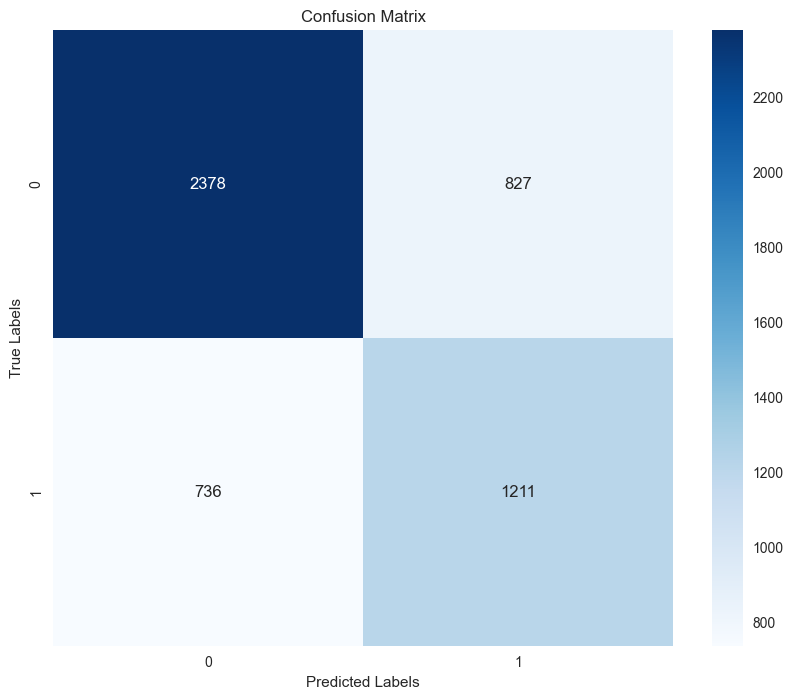

In [72]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

# Visualizing the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test_classes), yticklabels=np.unique(y_test_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


**ROC curve**

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step


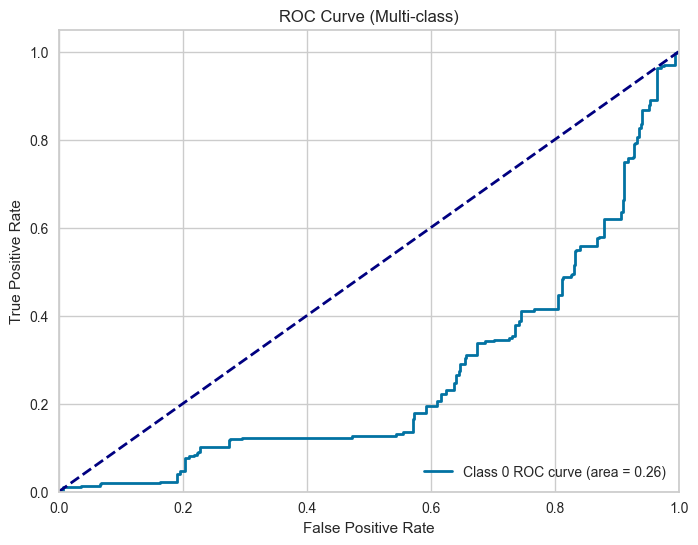

In [73]:
# Binarize the true labels (assuming two classes in your case, adjust if you have more)
y_test_bin = label_binarize(y_test_classes, classes=[0, 1])
# Predict probabilities for each class
y_pred_probs = model.predict(X_test)

# Initialize the plot
plt.figure(figsize=(8, 6))

# Compute ROC curve and AUC for each class
for i in range(y_test_bin.shape[1]):
    fpr, tpr, roc_thresholds = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} ROC curve (area = {roc_auc:.2f})')

# Plotting details
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multi-class)')
plt.legend(loc='lower right')
plt.show()



1. The ROC curve measures the trade-off between the true positive rate (TPR) and false positive rate (FPR) for different classification thresholds. The curve remains close to the diagonal line, which represents random guessing.

2. The area under the curve (AUC) is 0.28, which is significantly below 0.5. This indicates that the classifier performs worse than random chance for distinguishing "Class 0."


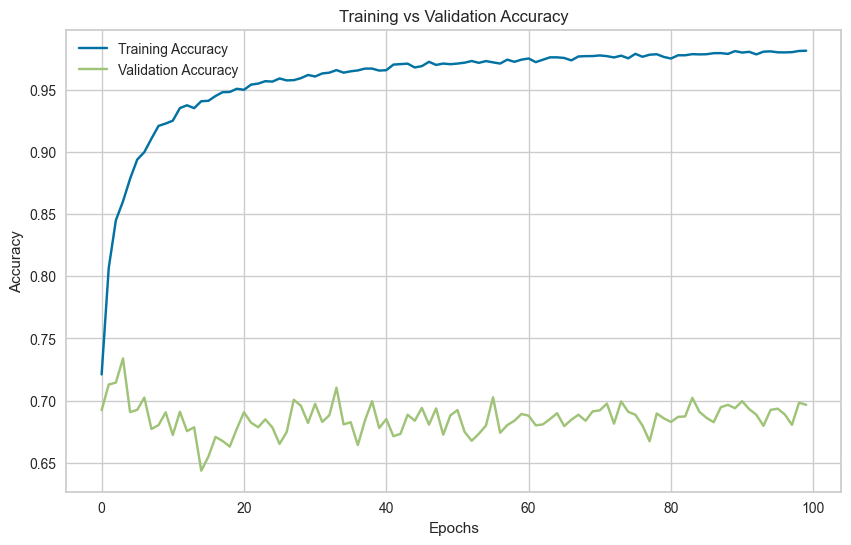

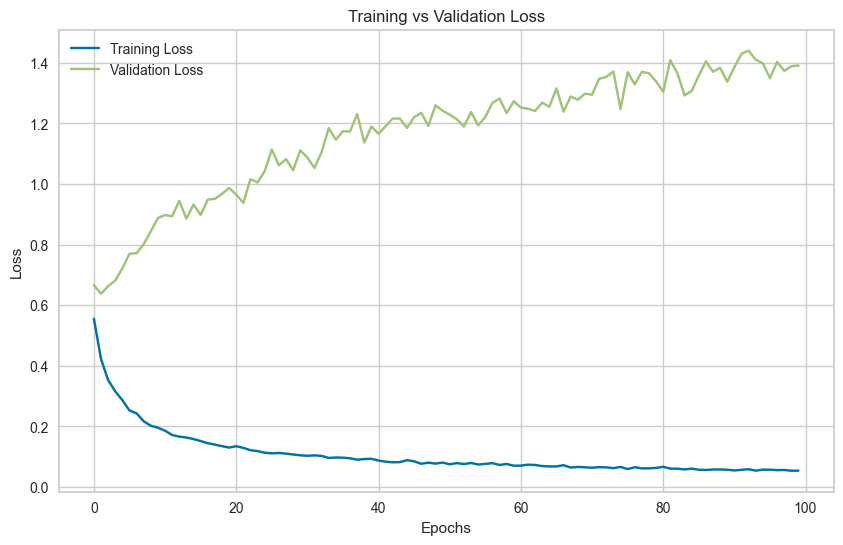

In [74]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()




1. **Training vs Validation Loss (First Graph)**: The training loss consistently decreases, indicating that the model is learning from the training data effectively. However, the validation loss begins to increase after a certain point.

2. **Training vs Validation Accuracy (Second Graph)**: The training accuracy improves steadily, approaching near-perfect accuracy. In contrast, the validation accuracy fluctuates significantly and remains much lower than the training accuracy.


# **7. Conclusion**

## **7.1 General Conclusion**

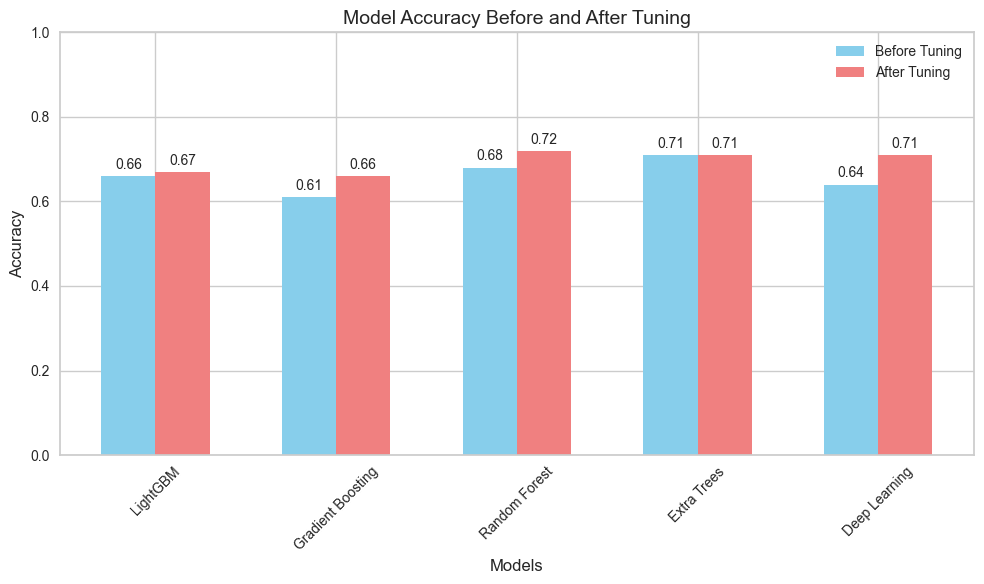

In [75]:
# Data from the previous steps
models = ['LightGBM', 'Gradient Boosting', 'Random Forest', 'Extra Trees', 'Deep Learning']
accuracy_before = [0.66, 0.61, 0.68, 0.71, 0.64]
accuracy_after = [0.67, 0.66, 0.72, 0.71, 0.71]

# Creating bar chart
x = np.arange(len(models))
width = 0.3

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, accuracy_before, width, label='Before Tuning', color='skyblue')
bars2 = ax.bar(x + width/2, accuracy_after, width, label='After Tuning', color='lightcoral')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Model Accuracy Before and After Tuning', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, fontsize=10)
ax.set_ylim(0, 1)
ax.legend(fontsize=10)

# Adding bar labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

add_labels(bars1)
add_labels(bars2)

# Show plot
plt.tight_layout()
plt.show()

Among all models, the `Random Forest Classifier` achieved the highest accuracy after tuning, improving from 0.68 to 0.72. It also had the best precision and recall after tuning, both reaching 0.72, reflecting its strong performance in correctly identifying both positive and negative classes. The confusion matrix also shows an improvement, with true positives increasing from 2514 to 2566, while false positives and false negatives were reduced.

The `Gradient Boosting Classifier` demonstrated the most significant improvement across all metrics, with its accuracy rising from 0.61 to 0.66 and its F1-score and precision increasing from 0.60 and 0.59 to 0.66 and 0.67, respectively. This improvement is evident in the confusion matrix, where true positives increased from 2484 to 2195, while false negatives decreased from 1257 to 1069.

The `LightGBM` model showed a minor but consistent improvement across all metrics, with accuracy increasing from 0.66 to 0.67 and similar gains in F1-score, precision, and recall. However, its overall performance lagged behind `Random Forest` and `Extra Trees`. The confusion matrix for `LightGBM` indicates a slight increase in false negatives after tuning, from 847 to 878.

The `Extra Trees Classifier` maintained stable performance, with no changes in any metric after tuning. Its accuracy, precision, and recall remained at 0.71, suggesting that its default configuration was already optimal for this dataset.

Finally, the `Deep Learning ANN` model showed notable improvement, with accuracy and recall increasing from 0.64 to 0.71, making it competitive with `Extra Trees`. The confusion matrix shows a significant increase in true positives, from 2070 to 2383, and a reduction in false negatives from 1273 to 1259.

In summary, the `Random Forest Classifier` stands out as the best-performing model overall, while `Gradient Boosting` and the `Deep Learning ANN` model displayed the greatest improvement after tuning. The stability of `Extra Trees` and the advancements in the `Deep Learning ANN` suggest varied strengths depending on the application requirements.

## 7.2 PyCaret vs. Our testing

The PyCaret table highlights LightGBM as the best-performing model, with the highest accuracy. However, our testing results differ slightly, showing Random Forest  as the top-performing model with improved accuracy. LightGBM, while ranking first in the PyCaret table, only achieves the third-best accuracy in our testing, although its results remain consistent across both tables (approximately 0.67 accuracy).

Interestingly, Random Forest and Extra Trees Classifier demonstrate stronger accuracy improvements in our testing compared to their PyCaret evaluations, while Gradient Boosting Classifier also shows significant performance gains. Both LightGBM and Gradient Boosting Classifier exhibit similar accuracies but lag slightly behind Random Forest and Extra Trees in our testing. The F1-scores, precision, and recall metrics from the testing table further emphasize Random Forest's superior performance.

In summary, while PyCaret identifies LightGBM as the best overall model, our testing underscores the robustness of Random Forest, particularly in accuracy and AUC performance. The comparative analysis suggests that model performance varies across different evaluation settings, with Random Forest emerging as the most reliable model in our tests.

## **7.3 Limitations**

One of the key limitations of our project is the restricted potential of our analysis due to the small size of the training and testing datasets. Due to the uneven distribution of the `is_active` column in datasets KB02 and KB05, they could not be used, even though they provided more rows. A larger dataset could provide more robust insights and improve the reliability of our findings. Additionally, a comprehensive understanding of cysteine structure is essential to fully grasp the nuances of the dataset. This prerequisite knowledge might pose a challenge for those without a strong background in this area, potentially limiting accessibility to broader audiences. Furthermore, while we applied various methods to enhance the performance of our deep learning model, these adjustments led to fluctuations in accuracy, even though they were necessary train our model against overfitting and to improve it.